In [1]:
# imports and setup
from os import listdir
import numpy as np
import pandas as pd
from matplotlib.colors import Normalize, hsv_to_rgb
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('data/all_years.csv', index_col=0)
len(df)

779223

In [3]:
# Group the columns into 1) raw input variables, 2) id variables of various things, 3) American Community Survey (census)
# variables, 4) NYC government-calculated variables, and 5) output variables.
#
# The ACS and NYC variables are generally calculated from the raw input variables - my initial expectation is that
# the raw input variables can be thought of as independent variables, and that the ACS and NYC variables are not
# independent even though they are not output variables.

raw_inp_vars = ['AGEP', 'Boro', 'CIT', 'DIS', 'ENG', 'ESR', 'Ethnicity', 'HHT', 'HIUnit_Head', 'HousingStatus', 'JWTR', 'LANX', 'MAR', 'MSP','NP', 'Off_Threshold', 'PreTaxIncome_PU', 'REL', 'SCH', 'SCHG', 'SCHL', 'SEX', 'TEN', 'WKHP', 'WKW', 'Year']

# Further group raw_inp_vars: a list of categories that will need to be bucketed for visualization, and those that won't
bucket_raw = ['AGEP', 'Off_Threshold', 'PreTaxIncome_PU', 'WKHP']
ok_raw = [var for var in raw_inp_vars if var not in bucket_raw]

id_vars = ['HIUnit_ID', 'Povunit_ID', 'PWGTP', 'SERIALNO', 'SNAPUnit_ID', 'SPORDER', 'TaxUnit_ID', 'WGTP']

acs_vars = ['AgeCateg', 'INTP_adj', 'OI_adj', 'MRGP_adj', 'PA_adj', 'RETP_adj', 'RNTP_adj', 'SEMP_adj', 'SSIP_adj', 'SSP_adj',  'WAGP_adj']

nyc_vars = ['CitizenStatus',  'EducAttain', 'FTPTWork', 'FamType_PU', 'NYCgov_Childcare', 'NYCgov_Commuting', 'NYCgov_EITC', 'NYCgov_FICAtax', 'NYCgov_HEAP', 'NYCgov_Housing', 'NYCgov_Income', 'NYCgov_IncomeTax', 'NYCgov_MOOP', 'NYCgov_MedPremiums', 'NYCgov_MedSpending', 'NYCgov_Nutrition', 'NYCgov_REL', 'NYCgov_SFN', 'NYCgov_SFR', 'NYCgov_SNAP', 'NYCgov_SchoolBreakfast', 'NYCgov_SchoolLunch', 'NYCgov_Threshold', 'NYCgov_WIC', 'Povunit_Rel', 'SNAPUnit_Rel',  'TaxUnit_FILER', 'TaxUnit_FILESTAT', 'TaxUnit_FILETYPE', 'TaxUnit_Rel', 'TotalWorkHrs_PU']

output_vars = ['NYCgov_PovGap', 'NYCgov_Pov_Stat', 'NYCgov_PovGapIndex', 'Off_Pov_Stat']

all_columns = raw_inp_vars + id_vars + acs_vars + nyc_vars + output_vars

print('Number of columns in groups: ' + str(len(all_columns)))
print('Total columns in dataframe: ' + str(len(df.columns)))
# Double-check that all of the columns in the dataframe are assigned to one and only one group
print("Set of all dataframe columns that don't appear in a group: " + str(set(df.columns).difference(set(all_columns))))

Number of columns in groups: 80
Total columns in dataframe: 80
Set of all dataframe columns that don't appear in a group: set()


In [4]:
# Create codes for the raw input variables that are number-coded, so we can create charts that make sense
raw_codes = {'Boro': {1: 'Bronx', 2: 'Brooklyn', 3: 'Manhattan', 4: 'Queens', 5: 'Staten Island'},
         'CIT': {1: 'Birth', 2: 'Territories', 3: 'US Parents', 4: 'Naturalized', 5: 'No'},
         'DIS': {0: 'NA', 1: 'Yes', 2: 'No'},
         'ENG': {0: '<5', 1: 'Very Well', 2: 'Well', 3: 'Not well', 4: 'Not at all', 5: 'Only Eng'},
         'ESR': {0: '<16', 1: 'EMP', 2:'EMP/NAW', 3: 'UNEMP', 4: 'AF', 5: 'AF/NAW', 6:'NILF'},
         'Ethnicity': {1: 'White', 2: 'Black', 3: 'Asian', 4: 'Hispanic', 5: 'Other'},
         'HHT': {0: 'NA', 1: 'MAR', 2: 'MNW', 3: 'WNM', 4: 'Malone', 5: 'MNAlone', 6: 'Walone', 7: 'WNalone'},
         'HIUnit_Head': {0: 'Not Head', 1: 'Head', 2: 'Not Head'},
         'HousingStatus': {0: 'NA', 1: 'Public', 2: 'Mitchell', 3: 'Subsidy', 4: 'Regulated', 5: 'OtherReg', 6: 'MarketRate', 7: 'NoCash', 8: 'OwnF&C', 9: 'Own-Mortgage'},
         'JWTR': {0: 'NA', 1: 'Car', 2: 'Bus', 3:'Streetcar', 4:'Subway', 5:'RR', 6:'Ferry', 7:'Taxi', 8:'Motorcycle', 9:'Bike', 10:'Walk', 11:'Home', 12: 'Other'},
         'LANX': {0: 'NA', 1: 'Yes', 2: 'Only Eng'},
         'MAR': {1: 'Married', 2:'Widowed', 3:'Divorced', 4:'Separated', 5:'Never Married'},
         'MSP': {0: 'NA', 1: 'Yes', 2:'Spouse absent', 3:'Widowed', 4:'Divorced', 5:'Separated', 6:'Never Married'},
         'REL': {0: 'Self', 1:'Spouse', 2:'Child', 3:'Adopted', 4:'Stepchild', 5:'Sibling', 6:'Parent', 7:'Grandchild', 8:'Parent-in-law', 9:'Child-in-law', 10:'Other', 11:'Boarder', 12:'Roommate', 13:'Partner', 14:'Foster', 15:'OtherNR', 16:'Inst', 17:'NonInst'},
         'SCH': {0: 'NA', 1: 'NoPast3Mos', 2:'Public', 3:'Private/Home'},
         'SCHG': {0: 'NA', 1:'Preschool', 2:'Kindergarten', 3:'1', 4:'2', 5:'3', 6:'4', 7:'5', 8:'6', 9:'7', 10:'8', 11:'9', 12:'10', 13:'11', 14:'12', 15:'College', 16:'Grad school'},
         'SCHL': {0: 'NA', 1:'None', 2:'Preschool', 3:'Kindergarten', 4:'1', 5:'2', 6:'3', 7:'4', 8:'5', 9:'6', 10:'7', 11:'8', 12:'9', 13:'10', 14:'11', 15:'12-NoDip', 16:'Diploma', 17:'GED', 18:'<1yrCollege', 19:'CollNoDegree', 20:'Associates', 21:'Bachelors', 22:'Masters', 23:'Professional', 24:'Doctorate'},
         'SEX': {1:'Male', 2:'Female'},
         'TEN': {0: 'NA', 1:'Mortage', 2:'Free&Clear', 3:'Rent', 4:'OccButNoRent'},
         'WKW': {0:'NA', 1:'50-52', 2:'48-49', 3:'40-47', 4:'27-39', 5:'14-26', 6:'<13'},
        }

In [5]:
# Create codes for the nyc variables that are number-coded, so we can create charts that make sense
nyc_codes = {
    'CitizenStatus': {1: 'Birth', 2: 'Naturalized', 3: 'No'},
    'EducAttain': {0: 'NA', 1:'<HS', 2:'HS', 3:'SomeCollege', 4:'Bachelors+'},
    'FTPTWork': {1:'FTYR', 2:'<FTYR', 3:'None'},
    'FamType_PU': {1:'Family', 2:'Couple', 3:'M+kid', 4:'W+kid', 5:'Mnokid', 6:'Wnokid', 7:'Unrelated', 8:'UnrelAlone'},
    'NYCgov_REL': {0:'Self', 1:'Spouse', 2:'Child', 3:'Sibling', 4:'Parent', 5:'Grandkid', 6:'Inlaw', 7:'OtherRel', 8:'Boarder', 9:'Roommate', 10:'Partner', 11:'FosterKid', 12:'OtherNonRel'},
    'NYCgov_SFR': {0: 'NA', 1:'NoKids', 2:'Kids', 3:'OneParent', 4:'Kid', 5:'Kid-Monly', 6:'Kid-Wonly'},
    'Povunit_Rel': {1:'Head', 2:'Spouse/Ptnr', 3:'Child', 4:'Other'},
    'SNAPUnit_Rel': {1:'Head', 2:'Spouse/Ptnr', 3:'Child', 4:'Other'},
    'TaxUnit_FILER': {1:'Filer', 0:'Non-Filer'},
    'TaxUnit_FILESTAT': {0: 'NA', 1:'Joint', 2:'HH', 3:'MFS', 4:'Single'},
    'TaxUnit_FILETYPE': {0: 'NA', 1: 'Normal', 2:'Dependent', 3:'BelowThresh'},
    'TaxUnit_Rel': {1:'Head', 2:'Spouse/Ptnr', 3:'Child', 4:'Other', 5:'EIC', 6:'Relative'},
    'TotalWorkHrs_PU': {1:'3500+', 2:'2340-3500', 3:'1750-2340', 4:'<1750', 5:'None'}
    }

In [6]:
# Create a dataframe 'cats' that uses categorical coding, rather than numerical coding, based on the dictionaries above.
cats = df.replace(nyc_codes)
cats = cats.replace(raw_codes)
cats = cats.replace({'NYCgov_Pov_Stat': {1: 'Pov', 2:'Not Pov'}, 
                     'Off_Pov_Stat': {1:'Pov', 2:'Not Pov'}, 
                     'AgeCateg': {1: 'U18', 2:'18-64', 3:'65+'}})

# Update one column so that NA's are all in one category
cats.loc[cats['HIUnit_Head'].isna(), 'HIUnit_Head'] = 'NA'

# List out the categories so we can check that it makes sense
for col in dict(raw_codes, **nyc_codes):
    print(col + ': ' + str(cats[col].unique()))

Boro: ['Brooklyn' 'Queens' 'Bronx' 'Manhattan' 'Staten Island']
CIT: ['Naturalized' 'Birth' 'No' 'US Parents' 'Territories']
DIS: ['No' 'Yes' 'NA']
ENG: ['Only Eng' '<5' 'Not well' 'Not at all' 'Very Well' 'Well']
ESR: ['NILF' 'EMP' '<16' 'UNEMP' 'EMP/NAW' 'AF' 'AF/NAW']
Ethnicity: ['Black' 'White' 'Hispanic' 'Asian' 'Other']
HHT: ['Malone' 'MNAlone' 'WNM' 'MAR' 'Walone' 'MNW' 'WNalone']
HIUnit_Head: ['NA' 'Head' 'Not Head']
HousingStatus: ['Own-Mortgage' 'OwnF&C' 'Subsidy' 'Regulated' 'MarketRate' 'OtherReg'
 'Public' 'NoCash' 'Mitchell' 'NA']
JWTR: ['NA' 'Car' 'Bus' 'Other' 'Subway' 'Taxi' 'Walk' 'Home' 'RR' 'Motorcycle'
 'Ferry' 'Bike' 'Streetcar']
LANX: ['Only Eng' 'NA' 'Yes']
MAR: ['Divorced' 'Never Married' 'Widowed' 'Separated' 'Married']
MSP: ['Divorced' 'Never Married' 'Widowed' 'Separated' 'Yes' 'NA'
 'Spouse absent']
REL: ['Self' 'Parent-in-law' 'Child' 'Spouse' 'Adopted' 'Roommate' 'Grandchild'
 'Sibling' 'Stepchild' 'Parent' 'Child-in-law' 'Other' 'Boarder' 'Partner'
 'Oth

In [7]:
# Our data set contains two sets of weights: household weights and person weights.  
# We need to separate out each column by whether it should be weighted as a household variable or a person variable.
# Lists to create weighted columns, separated based on whether they are personal or household statistics.
per_vars = ['AGEP', 'Boro', 'CIT', 'SCH', 'SCHG', 'SCHL', 'SEX', 'ESR', 'ENG', 'LANX', 'MSP', 'MAR', 'WKW', 'WKHP', 'DIS', 'JWTR', 'WAGP_adj', 'INTP_adj', 'SEMP_adj', 'SSP_adj', 'SSIP_adj', 'PA_adj', 'RETP_adj', 'OI_adj', 'MRGP_adj', 'RNTP_adj', 'Ethnicity', 'EducAttain', 'CitizenStatus', 'AgeCateg', 'FTPTWork'] 
hh_vars = ['NP', 'TEN', 'HHT', 'FamType_PU', 'HousingStatus', 'TotalWorkHrs_PU', 'PreTaxIncome_PU', 'NYCgov_EITC', 'NYCgov_Income', 'NYCgov_Threshold', 'NYCgov_Pov_Stat',  'NYCgov_Housing', 'NYCgov_Childcare', 'NYCgov_Commuting', 'NYCgov_MOOP', 'NYCgov_MedSpending', 'NYCgov_MedPremiums', 'NYCgov_HEAP', 'NYCgov_WIC', 'NYCgov_SNAP', 'NYCgov_SchoolLunch', 'NYCgov_SchoolBreakfast', 'NYCgov_Nutrition', 'NYCgov_FICAtax', 'NYCgov_IncomeTax', 'TaxUnit_Rel', 'NYCgov_REL', 'NYCgov_SFR', 'SNAPUnit_Rel', 'TaxUnit_FILER', 'TaxUnit_FILESTAT', 'TaxUnit_FILETYPE', 'NYCgov_PovGap', 'NYCgov_PovGapIndex']

# List out each grouping so we can check that it makes sense.
print('Columns weighted by person (' + str(len(per_vars)) + '): ' + str(per_vars) + '\n')
print('Columns weighted by household (' + str(len(hh_vars)) + '): ' + str(hh_vars) + '\n')
neither = [var for var in all_columns if var not in (per_vars + hh_vars)]
print('Not in either(' + str(len(neither)) + '): ' + str(neither))

Columns weighted by person (31): ['AGEP', 'Boro', 'CIT', 'SCH', 'SCHG', 'SCHL', 'SEX', 'ESR', 'ENG', 'LANX', 'MSP', 'MAR', 'WKW', 'WKHP', 'DIS', 'JWTR', 'WAGP_adj', 'INTP_adj', 'SEMP_adj', 'SSP_adj', 'SSIP_adj', 'PA_adj', 'RETP_adj', 'OI_adj', 'MRGP_adj', 'RNTP_adj', 'Ethnicity', 'EducAttain', 'CitizenStatus', 'AgeCateg', 'FTPTWork']

Columns weighted by household (34): ['NP', 'TEN', 'HHT', 'FamType_PU', 'HousingStatus', 'TotalWorkHrs_PU', 'PreTaxIncome_PU', 'NYCgov_EITC', 'NYCgov_Income', 'NYCgov_Threshold', 'NYCgov_Pov_Stat', 'NYCgov_Housing', 'NYCgov_Childcare', 'NYCgov_Commuting', 'NYCgov_MOOP', 'NYCgov_MedSpending', 'NYCgov_MedPremiums', 'NYCgov_HEAP', 'NYCgov_WIC', 'NYCgov_SNAP', 'NYCgov_SchoolLunch', 'NYCgov_SchoolBreakfast', 'NYCgov_Nutrition', 'NYCgov_FICAtax', 'NYCgov_IncomeTax', 'TaxUnit_Rel', 'NYCgov_REL', 'NYCgov_SFR', 'SNAPUnit_Rel', 'TaxUnit_FILER', 'TaxUnit_FILESTAT', 'TaxUnit_FILETYPE', 'NYCgov_PovGap', 'NYCgov_PovGapIndex']

Not in either(15): ['HIUnit_Head', 'Off_Thr

In [8]:
def df_for_pov_chart(dataframe, column, weights_column):
    '''Creates a chart-ready dataframe of weighted poverty rate by a single category in a column.
    Input: a dataframe, the name of the column of interest, and the name of the column containing the appropriate weights.
    Output: a chart-ready dataframe of weighted poverty rate by the category of interest.'''
    
    # If the weight is by household, need to filter by household head
    if weights_column == 'WGTP':
        counts = dataframe.loc[dataframe['Povunit_Rel'] == 'Head', ['NYCgov_Pov_Stat', column, weights_column]].groupby([column, 'NYCgov_Pov_Stat']).sum()
    else:
        counts = dataframe[['NYCgov_Pov_Stat', column, weights_column]].groupby([column, 'NYCgov_Pov_Stat']).sum()
        
    # count and create % poverty by column    
    subtotals = counts.sum(level=0)
    pcts = 100 * counts / subtotals
    pcts = pcts.unstack('NYCgov_Pov_Stat')
    
    # only return the % in poverty by column
    return pd.DataFrame(pcts[weights_column]['Pov'])

In [9]:
def df_for_stat_chart(dataframe, column, weights_column):
    '''Creates a chart-ready dataframe of a single category in a column.
    Input: a dataframe, the name of the column of interest, and the name of the column containing the appropriate weights.
    Output: a chart-ready dataframe of the category of interest.'''
    
    # If the weight is by household, need to filter by household head
    if weights_column == 'WGTP':
        counts = dataframe.loc[dataframe['Povunit_Rel'] == 'Head', [column, weights_column]].groupby(column).sum()
    else:
        counts = dataframe[[column, weights_column]].groupby(column).sum()
        
    # count and create % by column    
    subtotals = counts.sum(level=0)
    pcts = subtotals/sum(counts[weights_column])
    
    # only return the % in poverty by column
    return pcts

In [10]:
def scatter_combined(dataframe, column, ylim=35):
    '''Create a scatter plot of weighted poverty rate by a single column, all years combined.
    Input: a dataframe, a column name, and an optional upper y-limit for the chart.
    Output: no return value. Plots a scatter plot.'''
    
    # Set up initial variables
    weight = 'PWGTP' if column in per_vars else 'WGTP'

    # Create counts and percentages by column
    pcts = df_for_pov_chart(dataframe, column, weight)
    pcts = pcts.rename(columns={'Pov': 'Weighted Poverty Rate by ' + str(column) + ', All Years Combined'})

    # Show the chart
    chart = sns.scatterplot(data=pcts)
    chart.set_ylim(0,ylim)
    plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()])
    pass

In [11]:
def scatter_sub(dataframe, column, years=[2005, 2010, 2016]):
    '''Create multiple scatter plots of weighted poverty rate by a column, over certain years.
    Input: a dataframe, a column name, and an optional list of years.
    Output: no return value. Plots multiple scatter subplots.'''
    
    weight = 'PWGTP' if column in per_vars else 'WGTP'

    # Create the charts
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14,5), sharex=True, sharey=True)
    for year, axis in zip(years, range(3)):
        # If no data for that year, don't try to make a chart
        if len(dataframe.loc[(dataframe.Year == year) & (dataframe[column].notna())]) > 0:
            pcts = df_for_pov_chart(dataframe.loc[dataframe.Year == year], column, weight).reset_index()
            ax = pcts.plot(kind='scatter', x=column, y='Pov', title = 'Weighted Poverty Rate by ' + column + ' in ' + str(year), ax=axes[axis])
            ax.grid(which='major', axis='y')
            plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()])

In [12]:
def scatter_sub_stat(dataframe, column, years=[2005, 2010, 2016], ylimits=[0,0.25]):
    '''Create multiple scatter plots of a column, over certain years.
    Input: a dataframe, a column name, and an optional list of years.
    Output: no return value. Plots multiple scatter subplots.'''
    
    weight = 'PWGTP' if column in per_vars else 'WGTP'

    # Create the charts
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14,5), sharex=True, sharey=True)
    for year, axis in zip(years, range(3)):
        # If no data for that year, don't try to make a chart
        if len(dataframe.loc[(dataframe.Year == year) & (dataframe[column].notna())]) > 0:
            pcts = df_for_stat_chart(dataframe.loc[dataframe.Year == year], column, weight).reset_index()
            ax = pcts.plot(kind='scatter', x=column, y=weight, title = 'Weighted Population by ' + column + ' in ' + str(year), ax=axes[axis])
            ax.grid(which='major', axis='y')
            plt.gca().set_yticklabels(['{:.1f}%'.format(x*100) for x in plt.gca().get_yticks()])
            ax.set_ylim(ylimits[0], ylimits[1])

In [13]:
def bar_combined(dataframe, column):
    '''Create a bar chart of weighted poverty rate by a single column, all years combined.
    Input: a dataframe and a column name.
    Output: no return value. Plots a bar chart.'''
    
    weight = 'PWGTP' if column in per_vars else 'WGTP'
    pcts = df_for_pov_chart(dataframe, column, weight)
    pcts.plot.bar(title='Weighted Poverty Rate by ' + str(column) + ', All Years Combined', legend=None, color='bgrcymk')
    plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()])

In [14]:
def bar_sub(dataframe, column, years=[2005, 2010, 2016]):
    '''Create multiple bar charts of weighted poverty rate by a column, over certain years.
    Input: a dataframe, a column name, and an optional list of years.
    Output: no return value. Plots multiple bar subplots.'''
    
    weight = 'PWGTP' if column in per_vars else 'WGTP'

    # Create the charts
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14,5), sharex=True, sharey=True)
    for year, axis in zip([2005, 2010, 2016], range(3)):
        pcts = df_for_pov_chart(dataframe.loc[dataframe.Year == year], column, weight)
        ax = pcts.plot(kind='bar', title = 'Weighted Poverty Rate by ' + column + ' in ' + str(year), ax=axes[axis], legend=None, color='bgrcymk')
        ax.grid(which='major', axis='y')
        plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()])

In [15]:
def bar_sub_stat(dataframe, column, years=[2005, 2010, 2016]):
    '''Create multiple bar charts of a column, over certain years.
    Input: a dataframe, a column name, and an optional list of years.
    Output: no return value. Plots multiple bar subplots.'''
    
    weight = 'PWGTP' if column in per_vars else 'WGTP'

    # Create the charts
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14,5), sharex=True, sharey=True)
    for year, axis in zip([2005, 2010, 2016], range(3)):
        pcts = df_for_stat_chart(dataframe.loc[dataframe.Year == year], column, weight)
        ax = pcts.plot(kind='bar', title = 'Weighted Population by ' + column + ' in ' + str(year), ax=axes[axis], legend=None, color='bgrcymk')
        ax.grid(which='major', axis='y')
        plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 

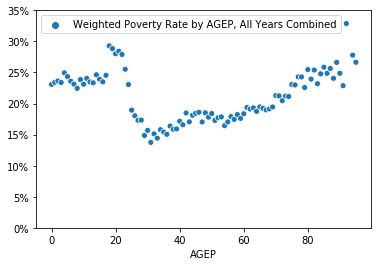

In [16]:
n = 0
scatter_combined(cats, raw_inp_vars[n])

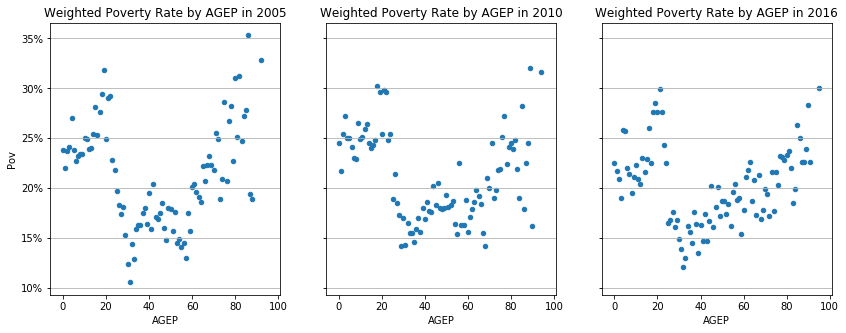

In [17]:
n = 0
scatter_sub(cats, raw_inp_vars[n])

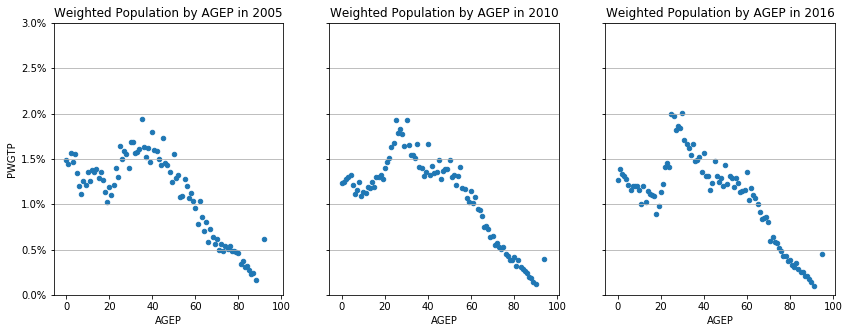

In [18]:
n = 0
scatter_sub_stat(cats, raw_inp_vars[n], ylimits=[0, 0.03])

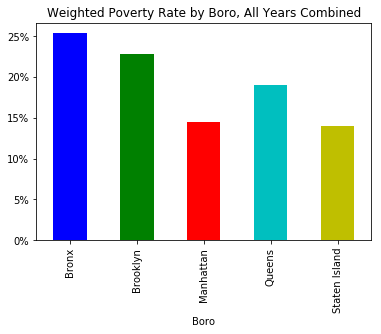

In [19]:
n = 1
bar_combined(cats, raw_inp_vars[n])

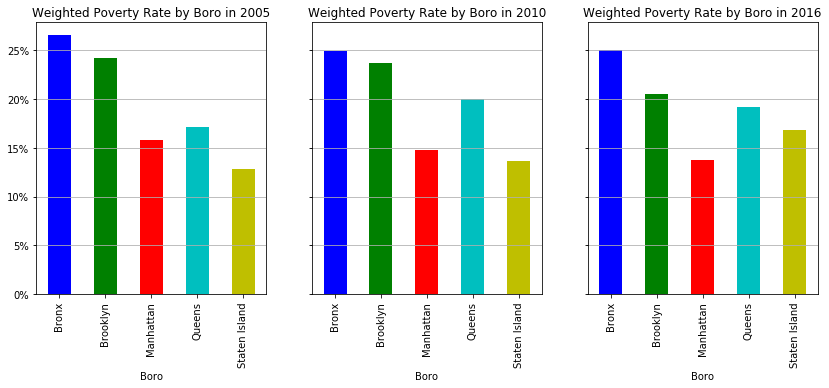

In [20]:
n = 1
bar_sub(cats, raw_inp_vars[n])

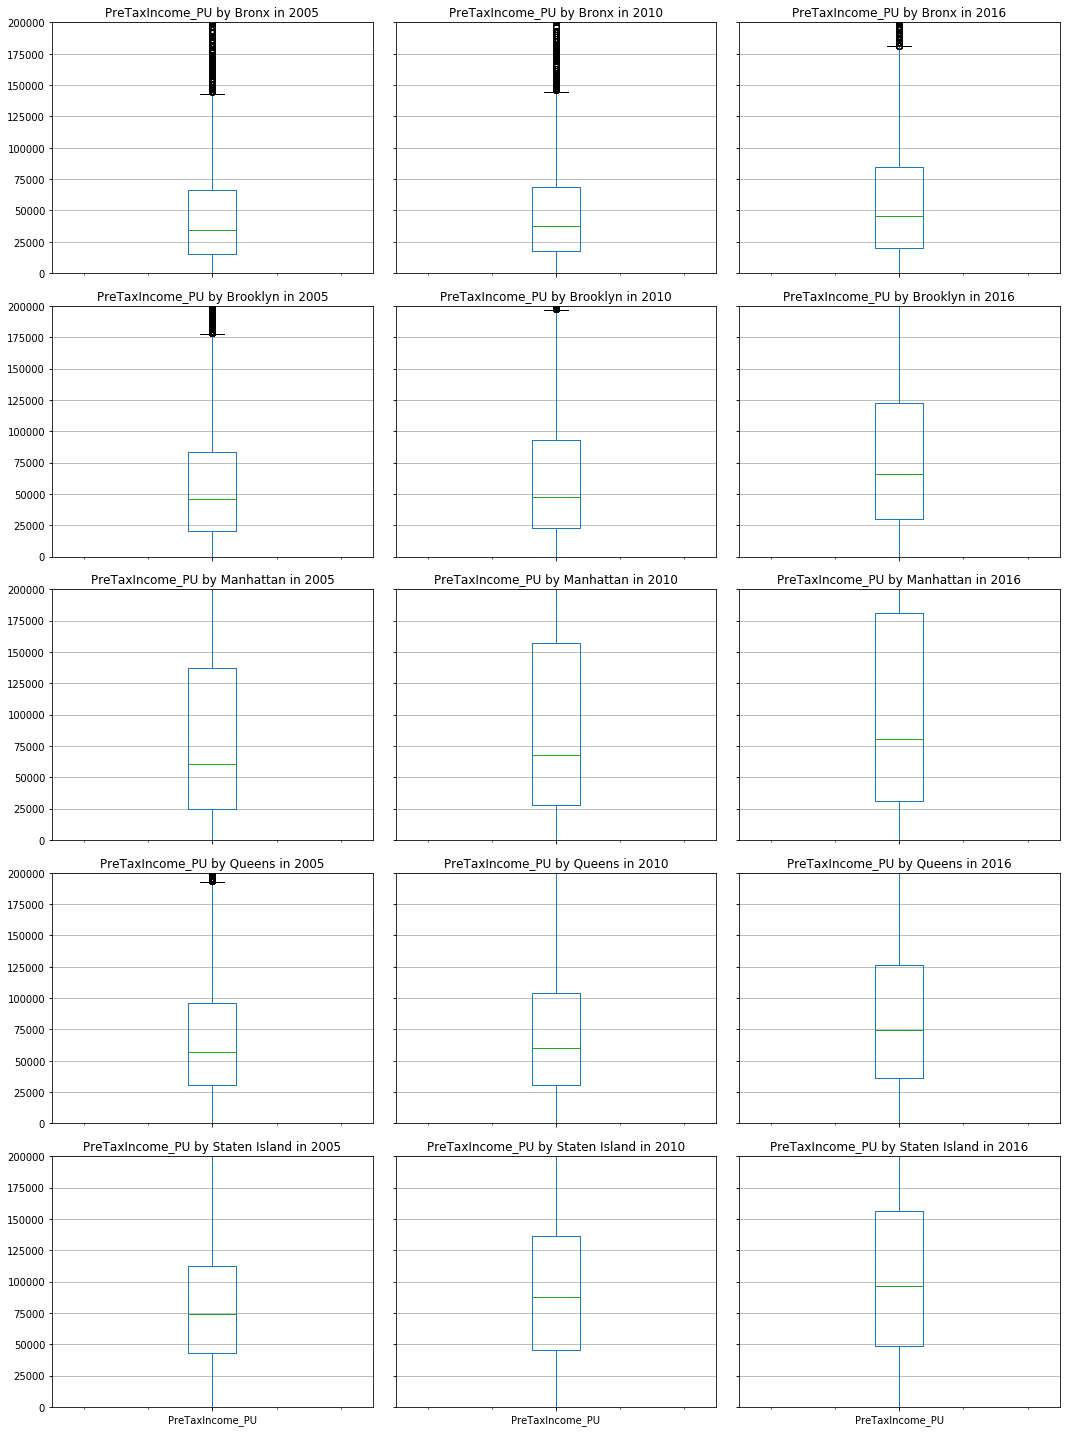

In [21]:
id = 'Boro'
group = raw_codes
target = 'PreTaxIncome_PU'
cols = 3
rows = len(group[id])
weight = 'PWGTP' if id in per_vars else 'WGTP'

def shim_row(x):
    if 0 in group[id]:
        return x
    else:
        return x - 1

fig, axes = plt.subplots(nrows=rows, ncols=cols, sharex=True, sharey=True)
fig.set_figheight(20)
fig.set_figwidth(15)

for row in group[id]:
    for year, col_axis in zip([2005, 2010, 2016], range(cols)):
        foc_df = cats.loc[(cats[id] == group[id][row]) & (cats['Year'] == year), target]
        
        chart_title = title = str(target) + ' by ' + str(group[id][row]) + ' in ' + str(year)
        ax = foc_df.plot(kind='box', title = chart_title, ax=axes[shim_row(row), col_axis], ylim=(0,200000))#, ylim=(0,150000), yticks=[0,25000,50000,75000,100000,125000,150000])
        ax.grid(which='major', axis='y')

plt.tight_layout()

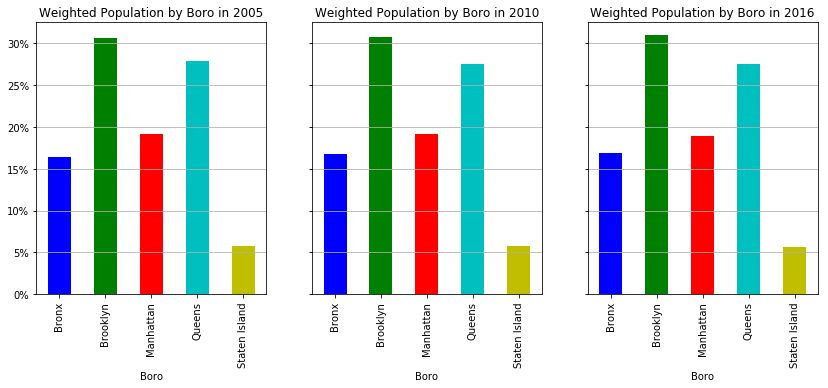

In [22]:
n = 1
bar_sub_stat(cats, raw_inp_vars[n])

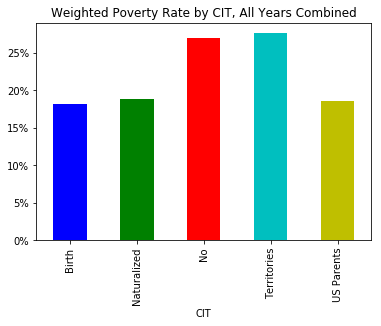

In [23]:
n = 2
bar_combined(cats, raw_inp_vars[n])

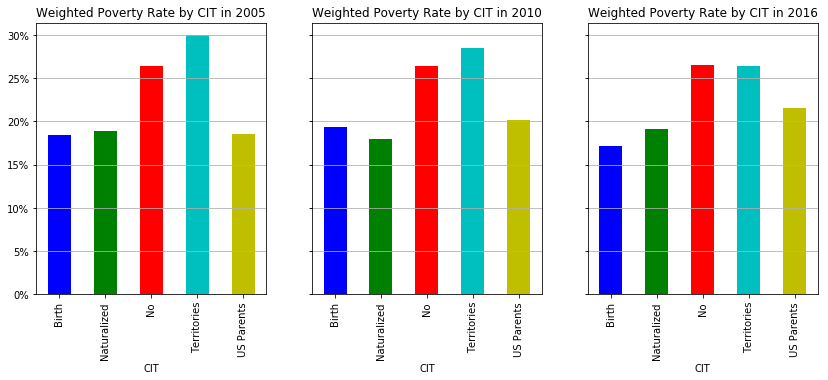

In [24]:
n = 2
bar_sub(cats, raw_inp_vars[n])

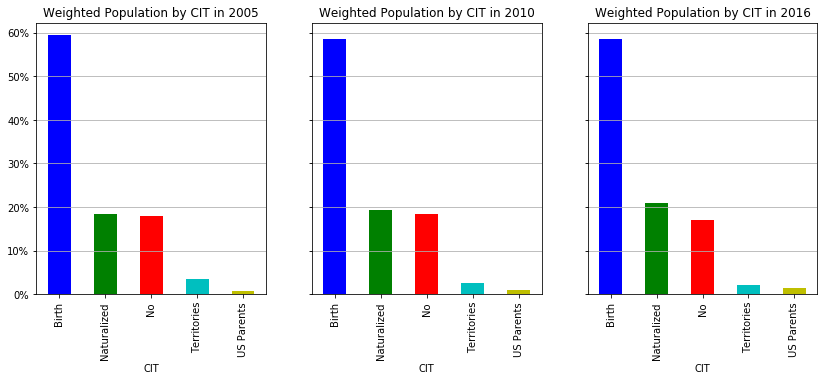

In [25]:
n = 2
bar_sub_stat(cats, raw_inp_vars[n])

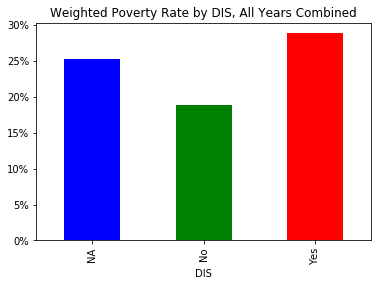

In [26]:
n = 3
bar_combined(cats, raw_inp_vars[n])

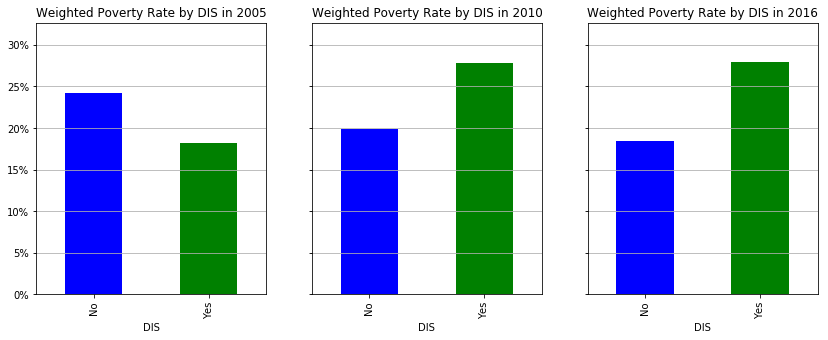

In [27]:
n = 3
bar_sub(cats, raw_inp_vars[n])

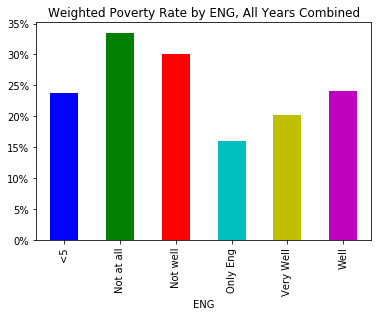

In [28]:
n = 4
bar_combined(cats, raw_inp_vars[n])

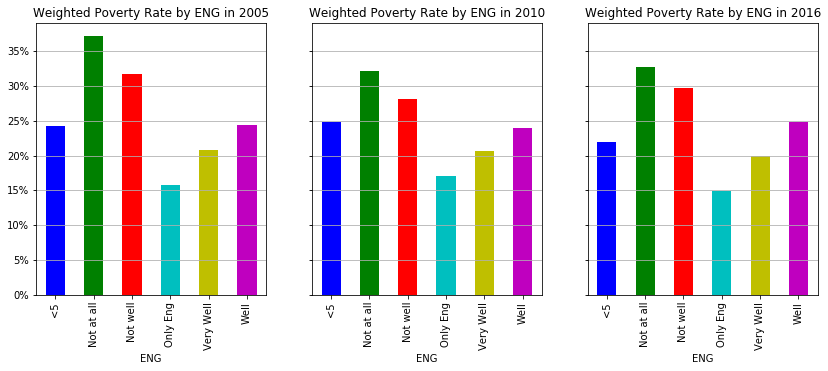

In [29]:
n = 4
bar_sub(cats, raw_inp_vars[n])

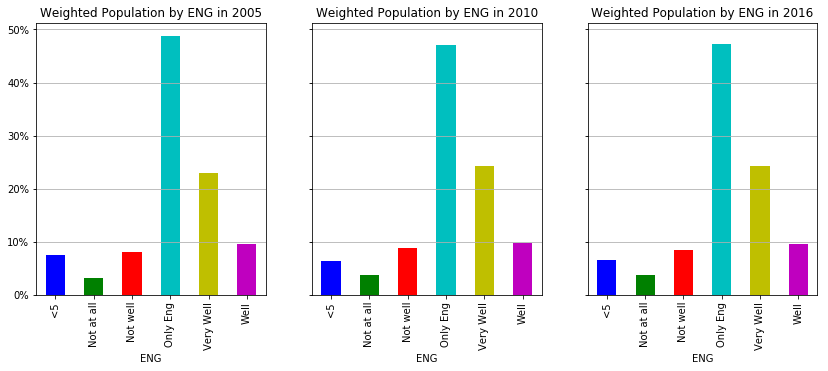

In [30]:
n = 4
bar_sub_stat(cats, raw_inp_vars[n])

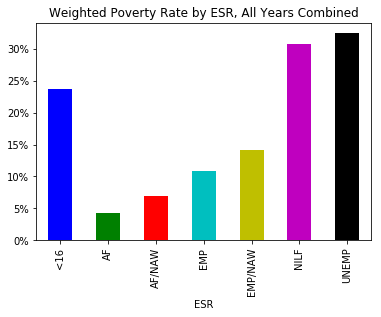

In [31]:
n = 5
bar_combined(cats, raw_inp_vars[n])

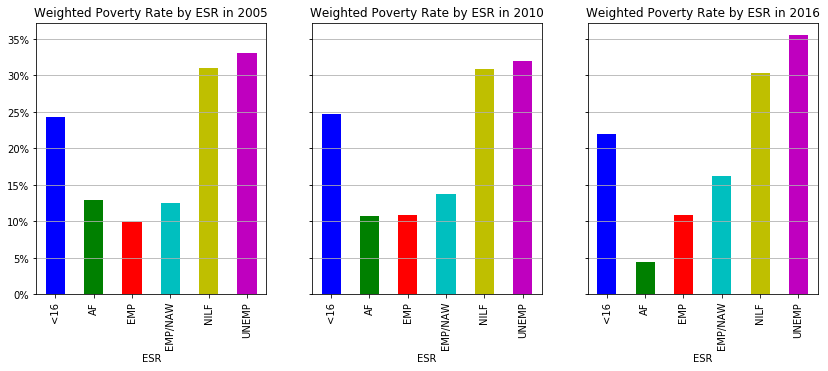

In [32]:
n = 5
bar_sub(cats, raw_inp_vars[n])

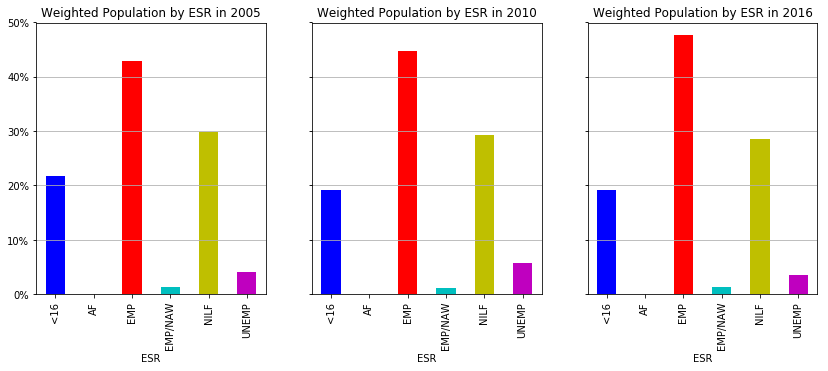

In [33]:
n = 5
bar_sub_stat(cats, raw_inp_vars[n])

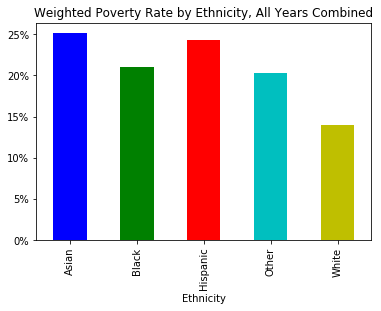

In [34]:
n = 6
bar_combined(cats, raw_inp_vars[n])

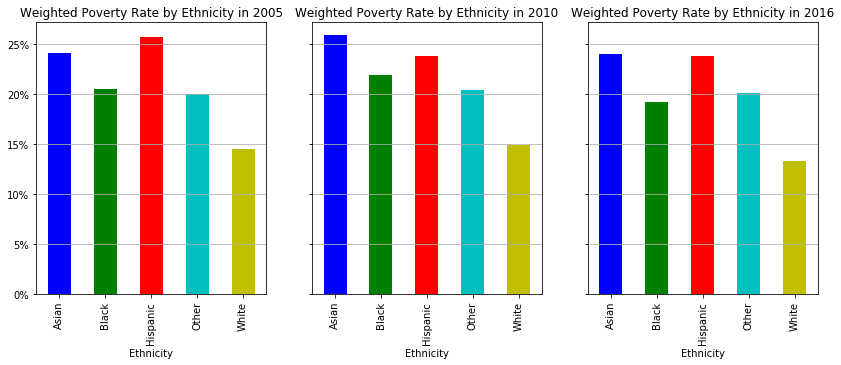

In [35]:
n = 6
bar_sub(cats, raw_inp_vars[n])

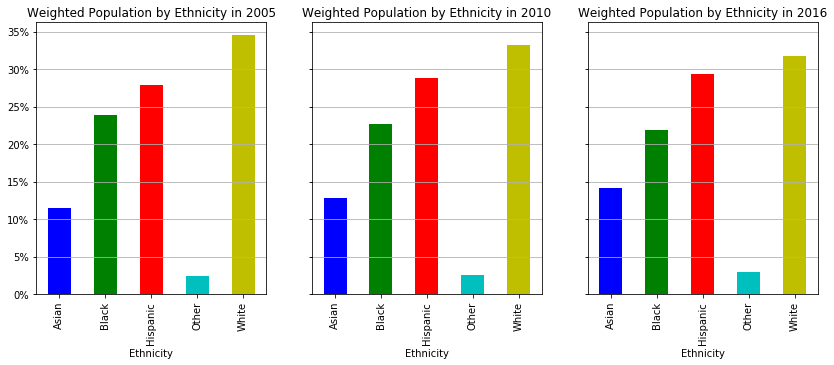

In [36]:
n = 6
bar_sub_stat(cats, raw_inp_vars[n])

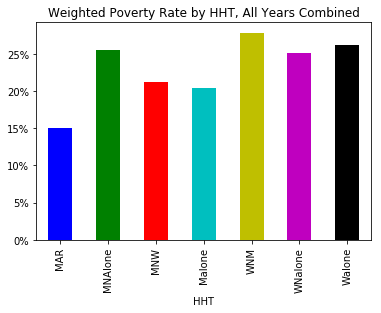

In [37]:
n = 7
bar_combined(cats, raw_inp_vars[n])

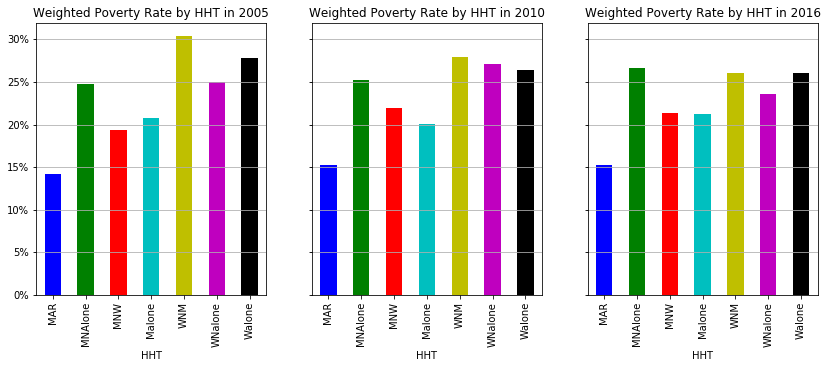

In [38]:
n = 7
bar_sub(cats, raw_inp_vars[n])

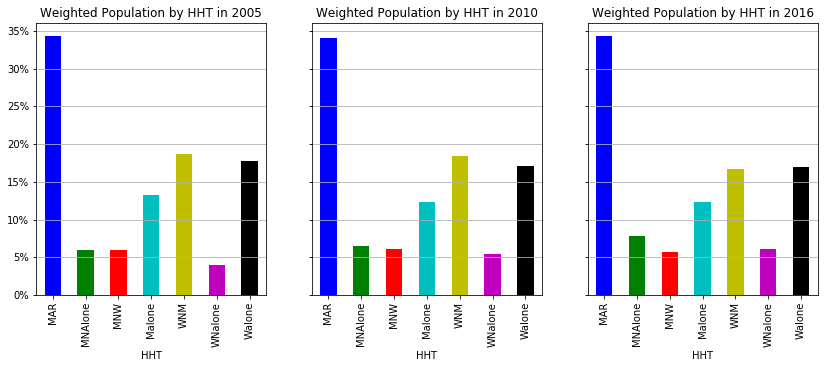

In [39]:
n = 7
bar_sub_stat(cats, raw_inp_vars[n])

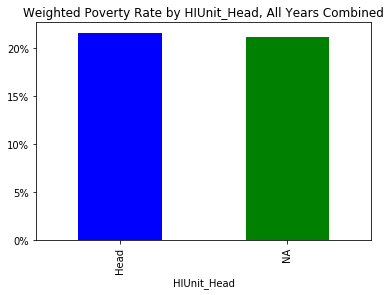

In [40]:
n = 8
bar_combined(cats, raw_inp_vars[n])

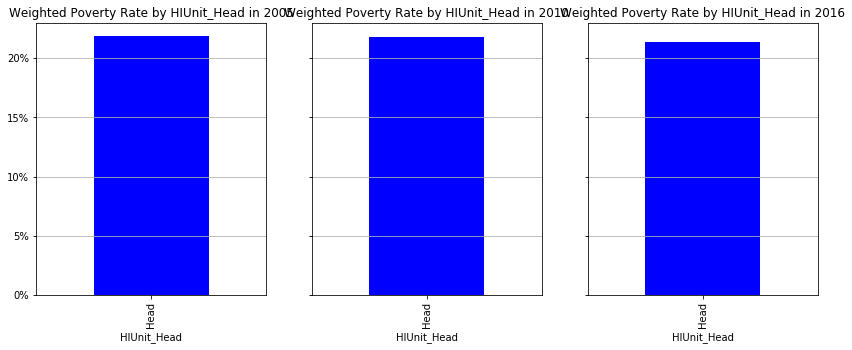

In [41]:
n = 8
bar_sub(cats, raw_inp_vars[n])

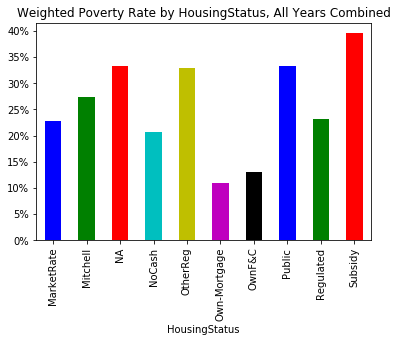

In [42]:
n = 9
bar_combined(cats, raw_inp_vars[n])

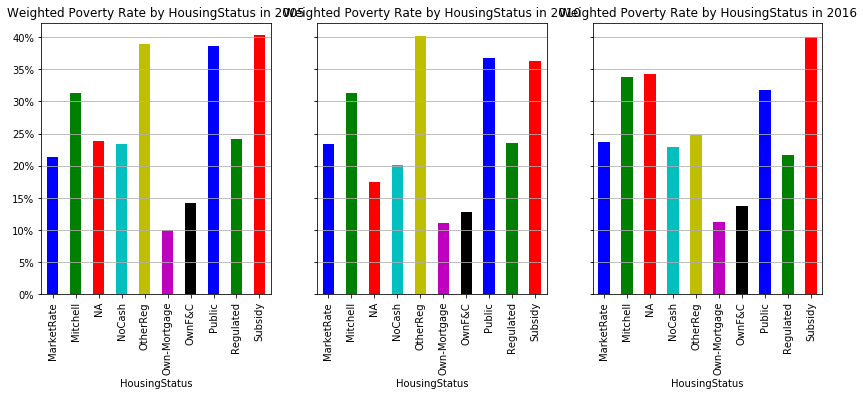

In [43]:
n = 9
bar_sub(cats, raw_inp_vars[n])

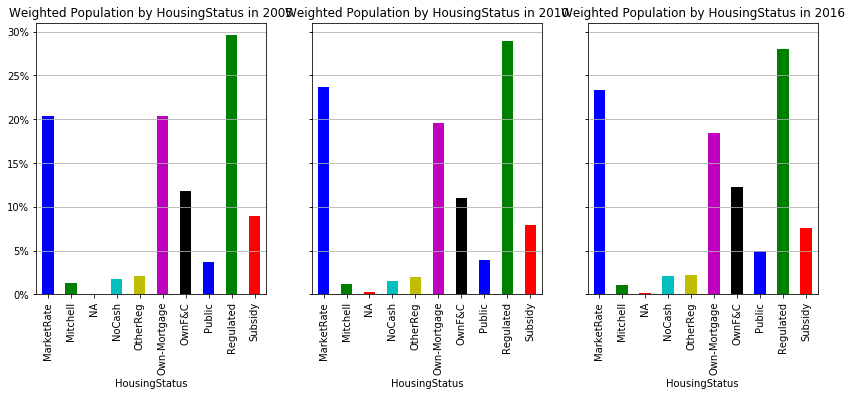

In [44]:
n = 9
bar_sub_stat(cats, raw_inp_vars[n])

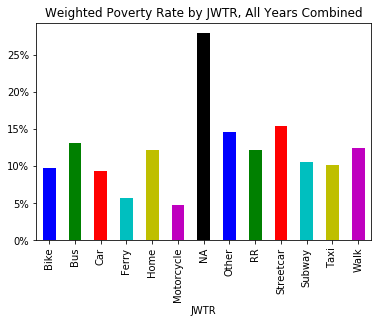

In [45]:
n = 10
bar_combined(cats, raw_inp_vars[n])

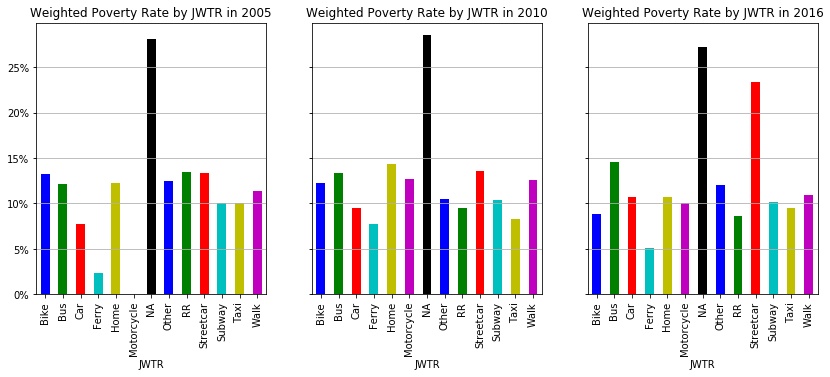

In [46]:
n = 10
bar_sub(cats, raw_inp_vars[n])

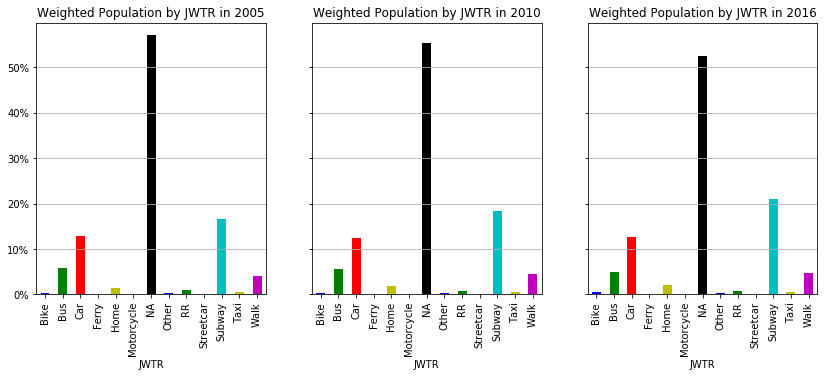

In [47]:
n = 10
bar_sub_stat(cats, raw_inp_vars[n])

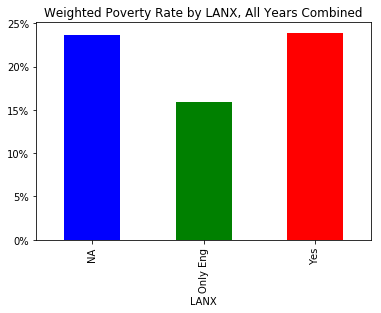

In [48]:
n = 11
bar_combined(cats, raw_inp_vars[n])

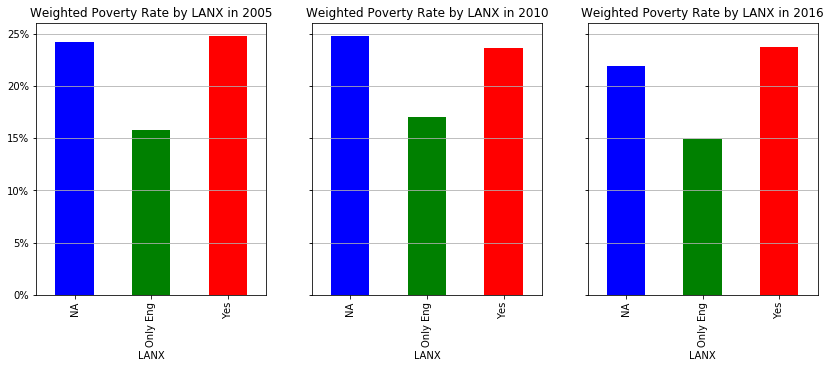

In [49]:
n = 11
bar_sub(cats, raw_inp_vars[n])

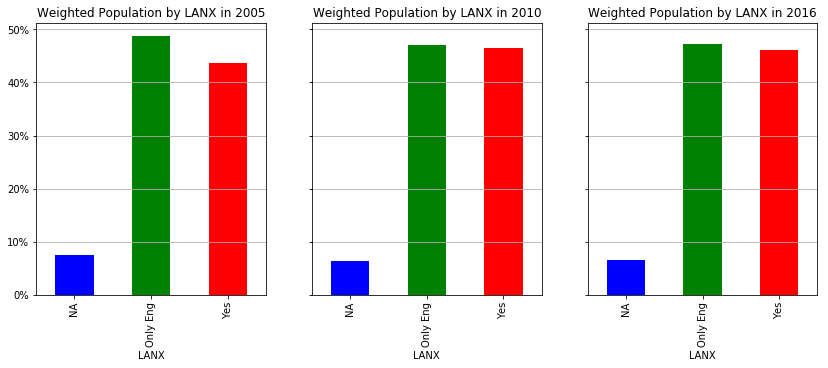

In [50]:
n = 11
bar_sub_stat(cats, raw_inp_vars[n])

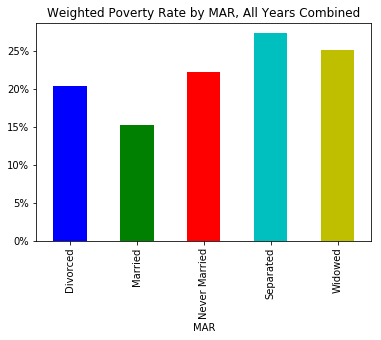

In [51]:
n = 12
bar_combined(cats, raw_inp_vars[n])

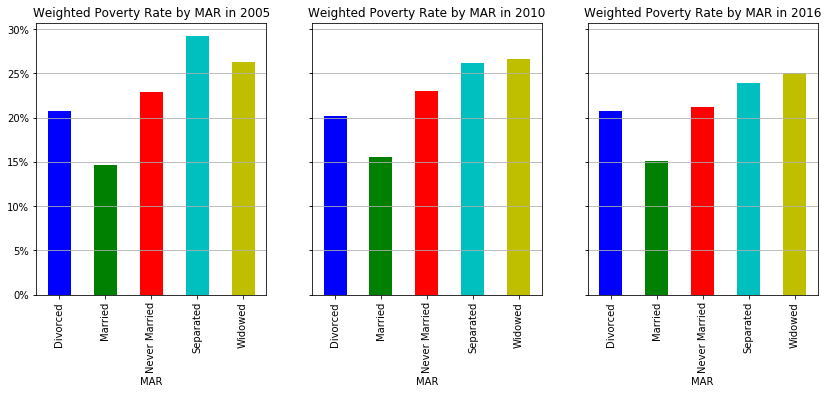

In [52]:
n = 12
bar_sub(cats, raw_inp_vars[n])

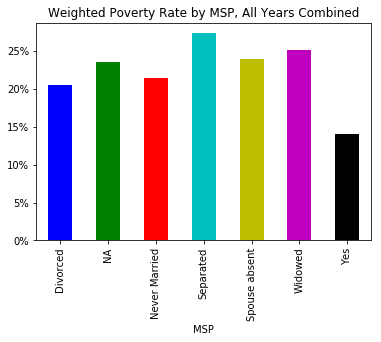

In [53]:
n = 13
bar_combined(cats, raw_inp_vars[n])

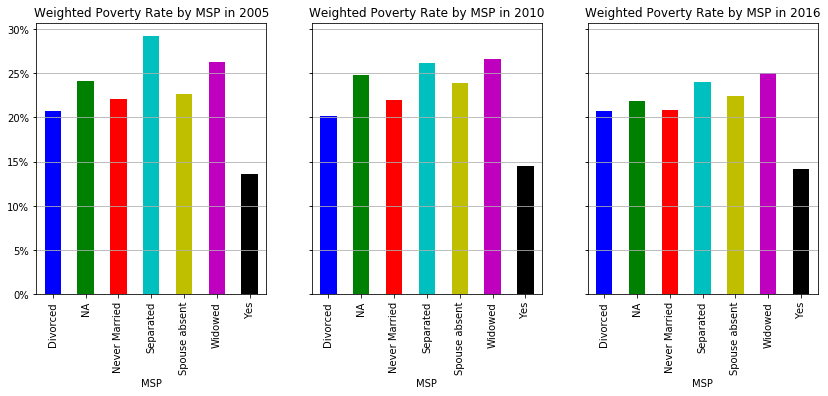

In [54]:
n = 13
bar_sub(cats, raw_inp_vars[n])

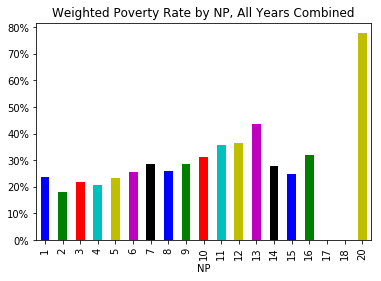

In [55]:
n = 14
bar_combined(cats, raw_inp_vars[n])

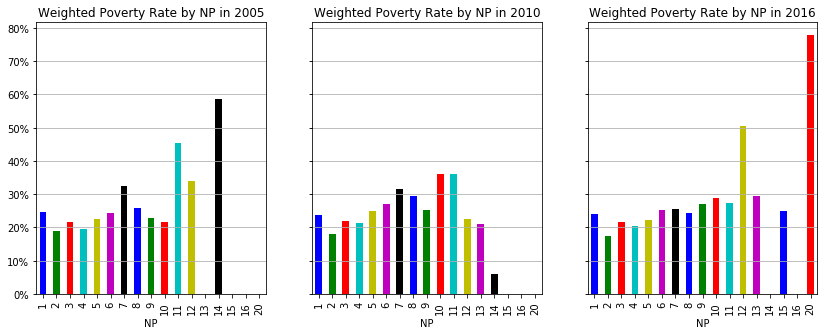

In [56]:
n = 14
bar_sub(cats, raw_inp_vars[n])

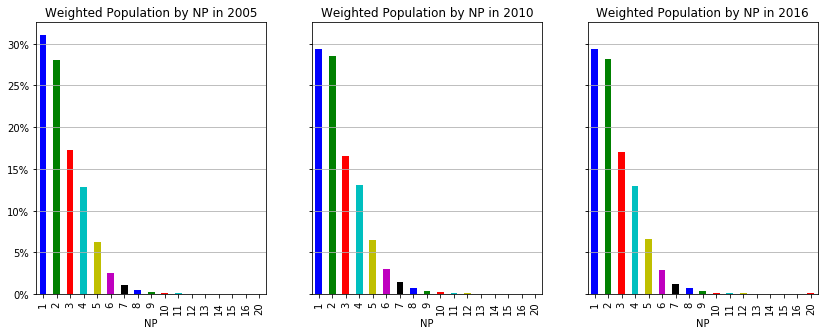

In [57]:
n = 14
bar_sub_stat(cats, raw_inp_vars[n])

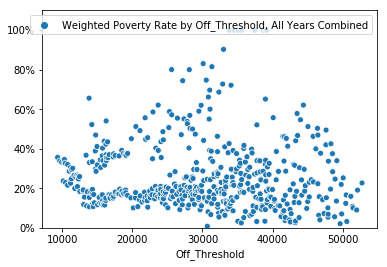

In [58]:
n = 15
scatter_combined(cats, raw_inp_vars[n], 110)

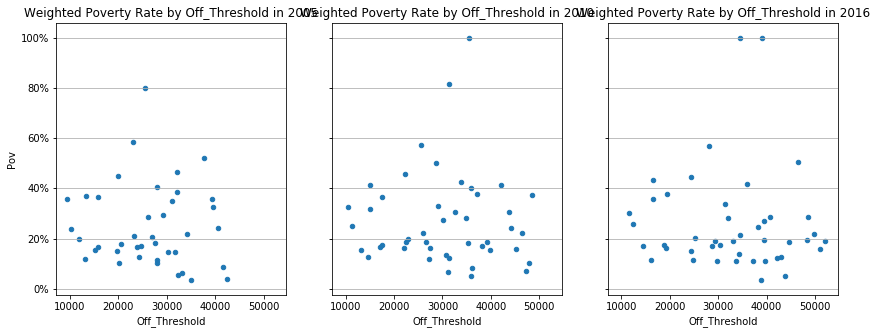

In [59]:
n = 15
scatter_sub(cats, raw_inp_vars[n])

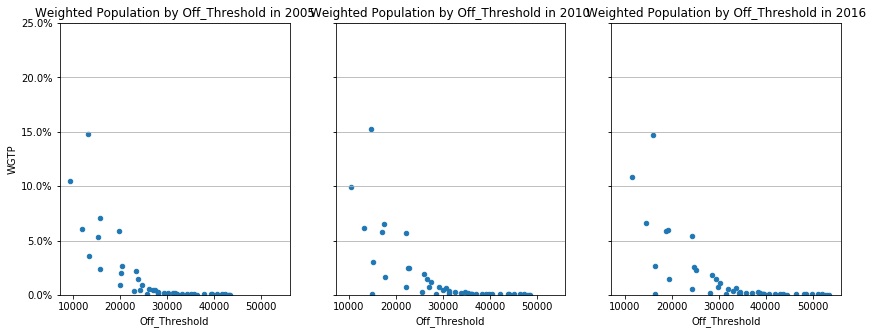

In [60]:
n = 15
scatter_sub_stat(cats, raw_inp_vars[n])

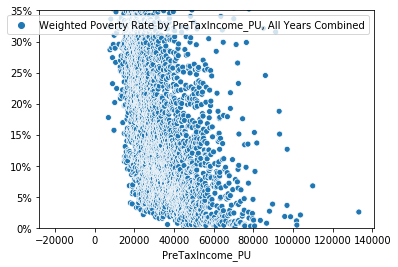

In [61]:
n = 16
scatter_combined(cats, raw_inp_vars[n])

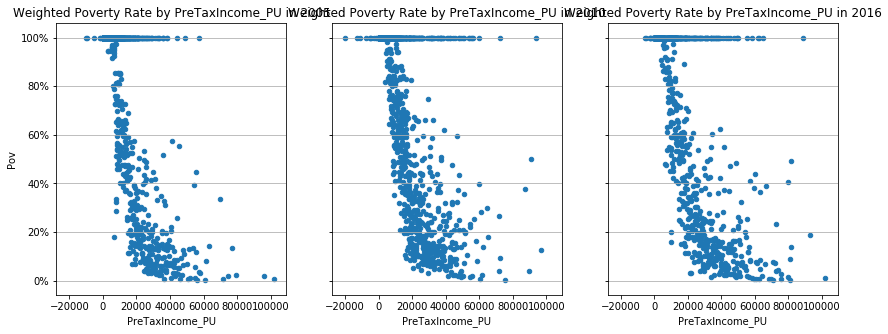

In [62]:
n = 16
scatter_sub(cats, raw_inp_vars[n])

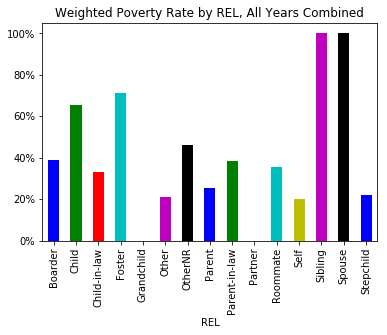

In [63]:
n = 17
bar_combined(cats, raw_inp_vars[n])

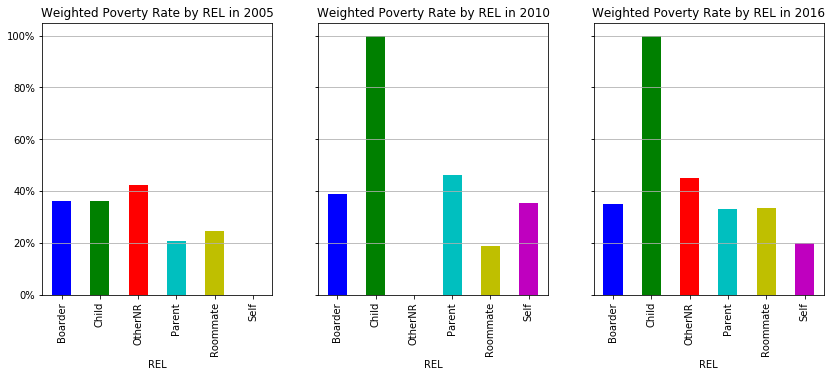

In [64]:
n = 17
bar_sub(cats, raw_inp_vars[n])

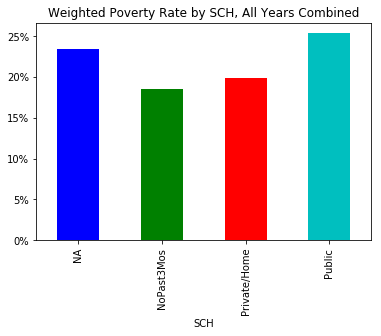

In [65]:
n = 18
bar_combined(cats, raw_inp_vars[n])

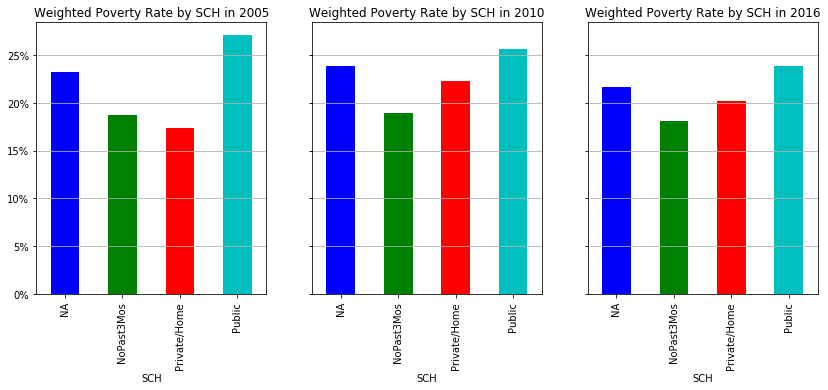

In [66]:
n = 18
bar_sub(cats, raw_inp_vars[n])

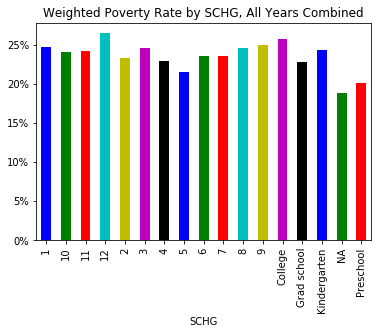

In [67]:
n = 19
bar_combined(cats, raw_inp_vars[n])

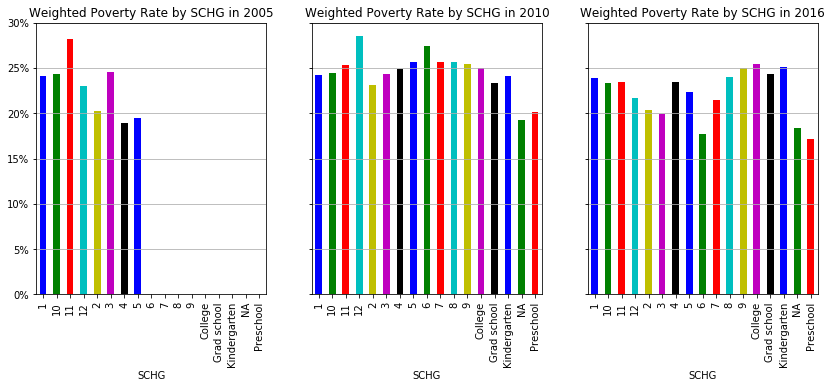

In [68]:
n = 19
bar_sub(cats, raw_inp_vars[n])

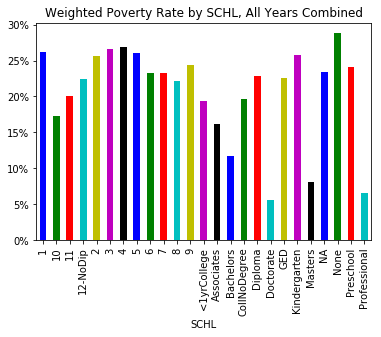

In [69]:
n = 20
bar_combined(cats, raw_inp_vars[n])

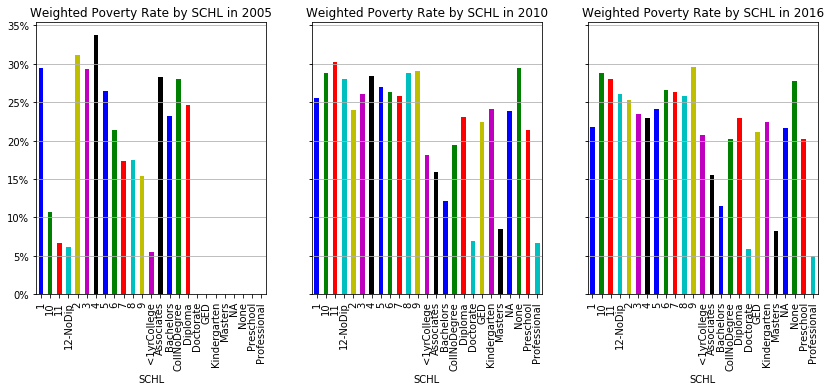

In [70]:
n = 20
bar_sub(cats, raw_inp_vars[n])

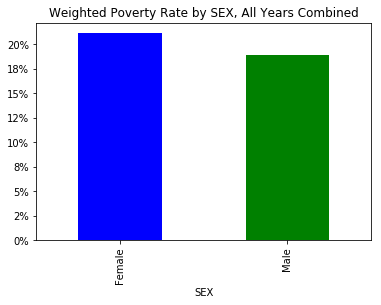

In [71]:
n = 21
bar_combined(cats, raw_inp_vars[n])

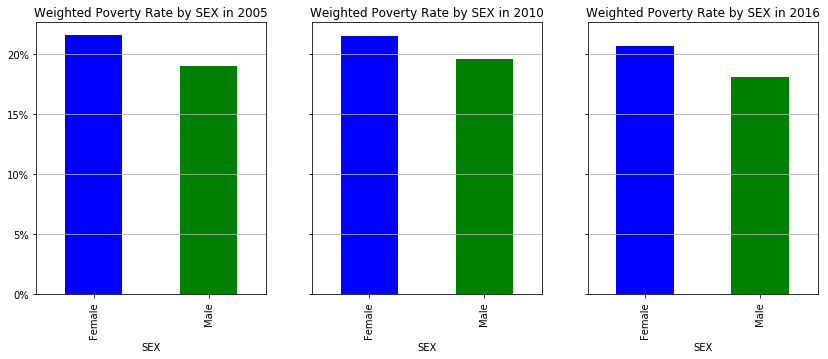

In [72]:
n = 21
bar_sub(cats, raw_inp_vars[n])

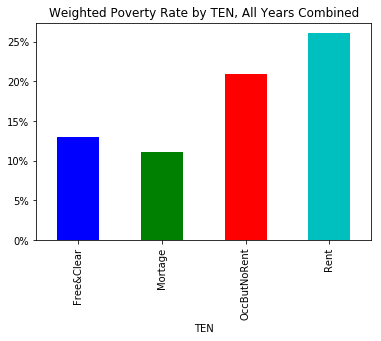

In [73]:
n = 22
bar_combined(cats, raw_inp_vars[n])

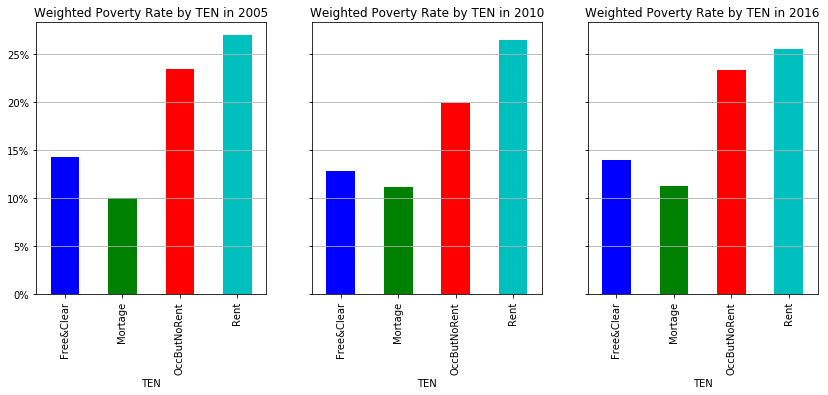

In [74]:
n = 22
bar_sub(cats, raw_inp_vars[n])

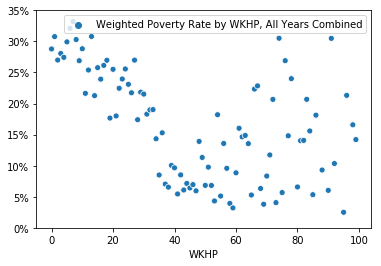

In [75]:
n = 23
scatter_combined(cats, raw_inp_vars[n])

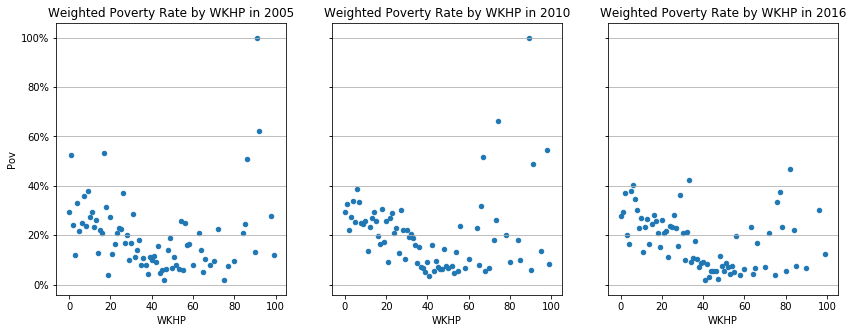

In [76]:
n = 23
scatter_sub(cats, raw_inp_vars[n])

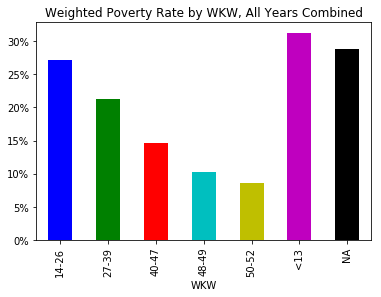

In [77]:
n = 24
bar_combined(cats, raw_inp_vars[n])

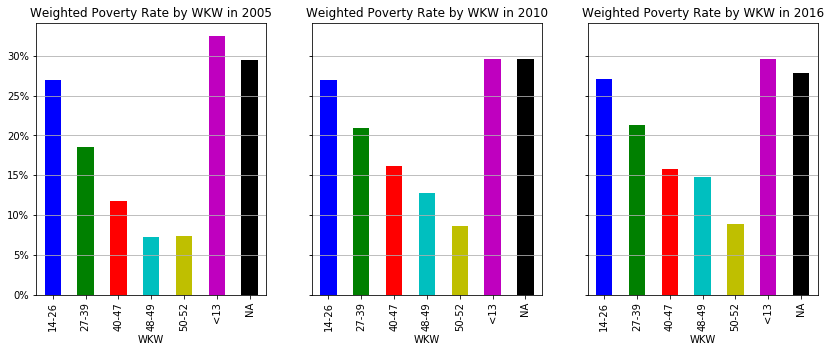

In [78]:
n = 24
bar_sub(cats, raw_inp_vars[n])

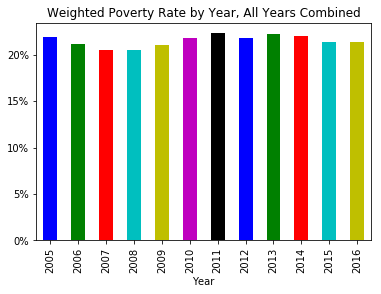

In [79]:
n = 25
bar_combined(cats, raw_inp_vars[n])

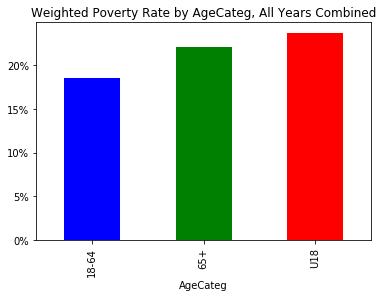

In [80]:
n = 0
bar_combined(cats, acs_vars[n])

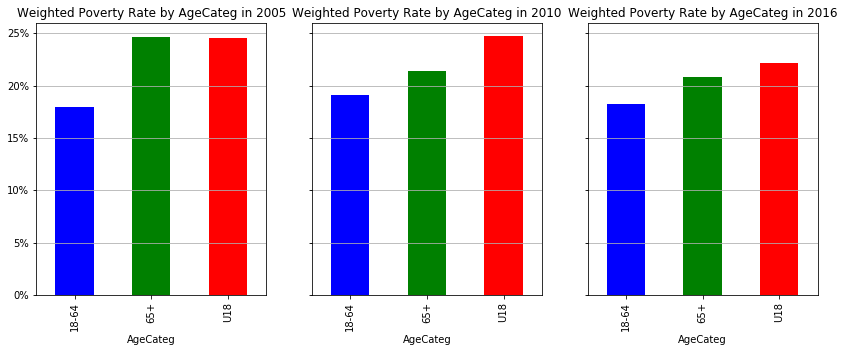

In [81]:
n = 0
bar_sub(cats, acs_vars[n])

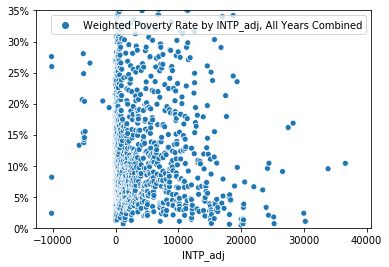

In [82]:
n = 1
scatter_combined(cats, acs_vars[n])

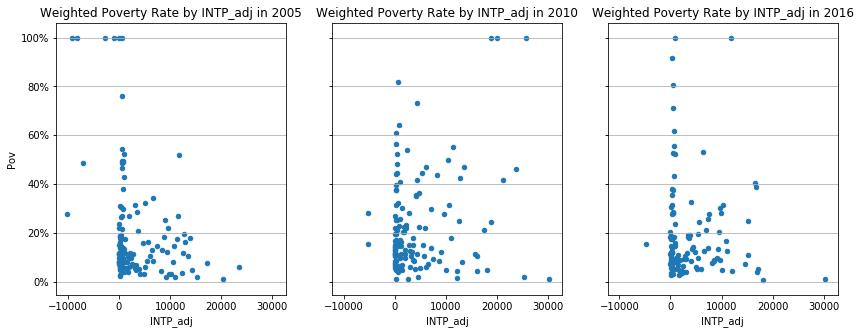

In [83]:
n = 1
scatter_sub(cats, acs_vars[n])

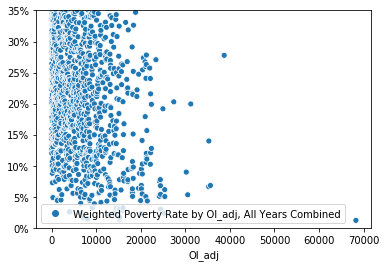

In [84]:
n = 2
scatter_combined(cats, acs_vars[n])

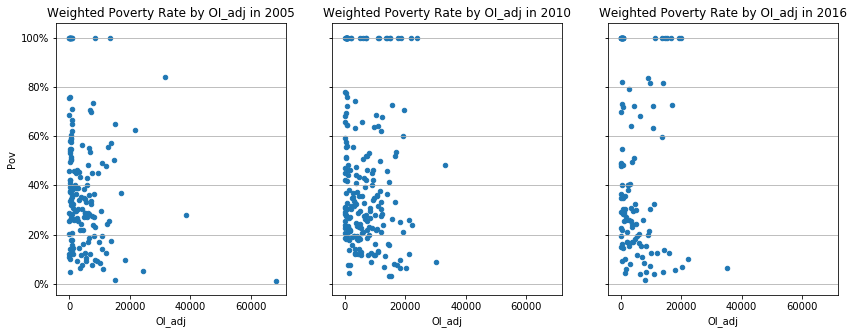

In [85]:
n = 2
scatter_sub(cats, acs_vars[n])

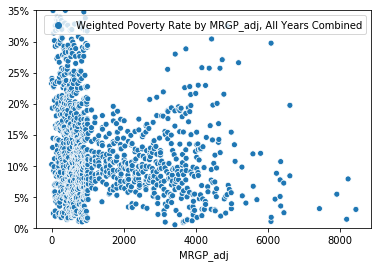

In [86]:
n = 3
scatter_combined(cats, acs_vars[n])

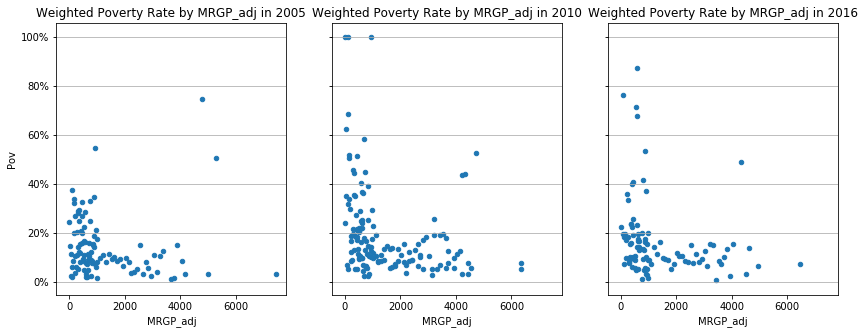

In [87]:
n = 3
scatter_sub(cats, acs_vars[n])

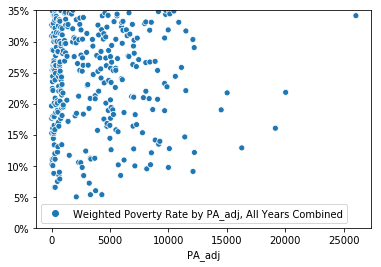

In [88]:
n = 4
scatter_combined(cats, acs_vars[n])

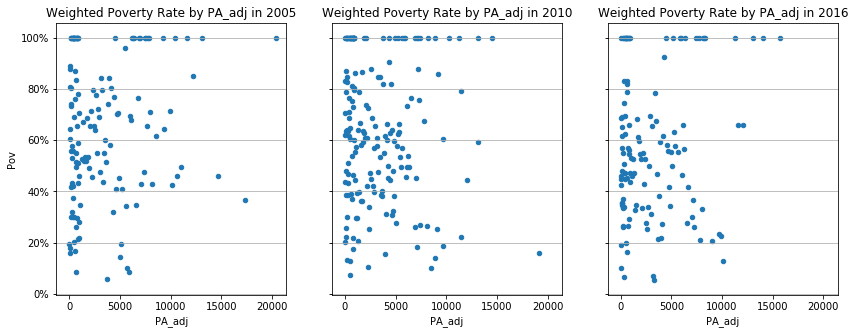

In [89]:
n = 4
scatter_sub(cats, acs_vars[n])

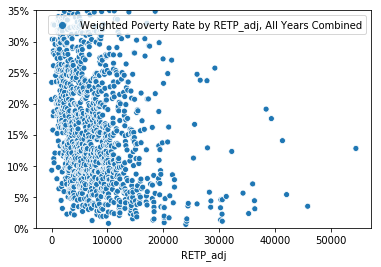

In [90]:
n = 5
scatter_combined(cats, acs_vars[n])

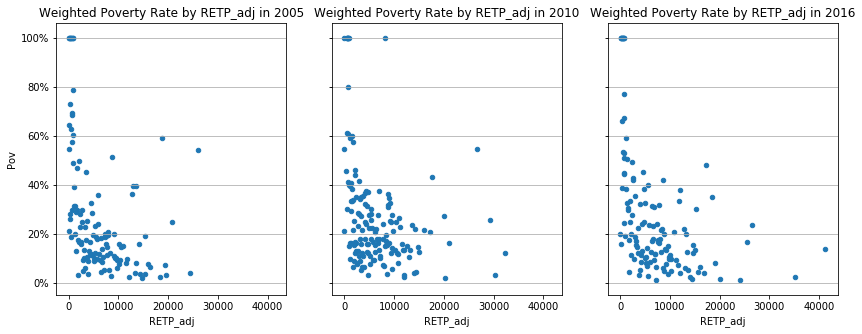

In [91]:
n = 5
scatter_sub(cats, acs_vars[n])

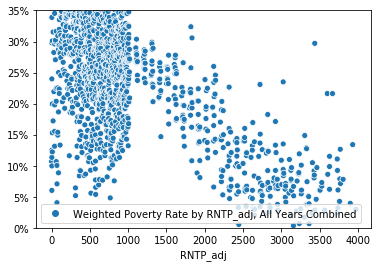

In [92]:
n = 6
scatter_combined(cats, acs_vars[n])

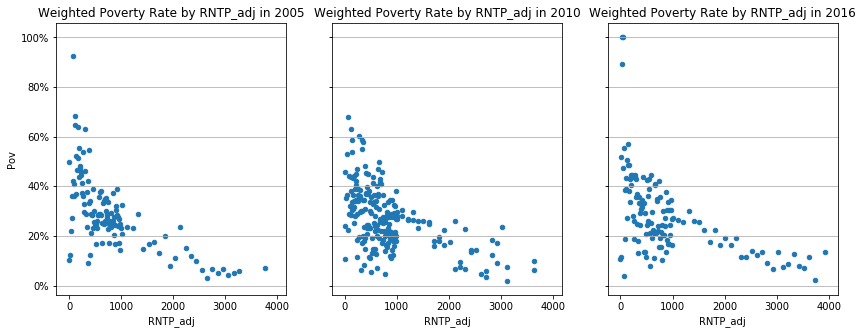

In [93]:
n = 6
scatter_sub(cats, acs_vars[n])

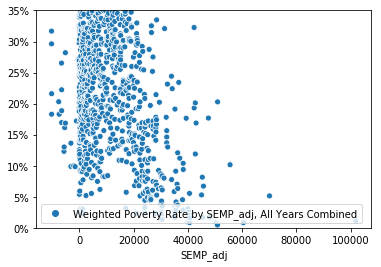

In [94]:
n = 7
scatter_combined(cats, acs_vars[n])

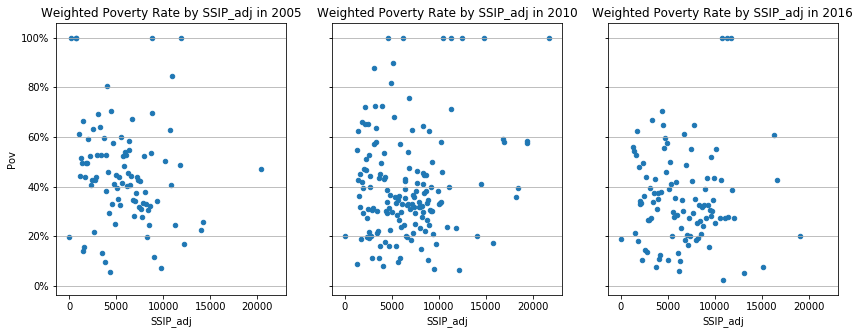

In [95]:
n = 8
scatter_sub(cats, acs_vars[n])

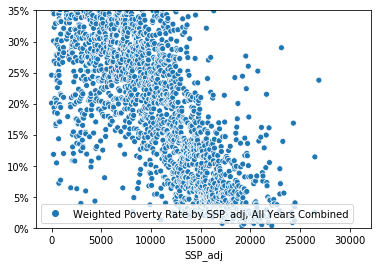

In [96]:
n = 9
scatter_combined(cats, acs_vars[n])

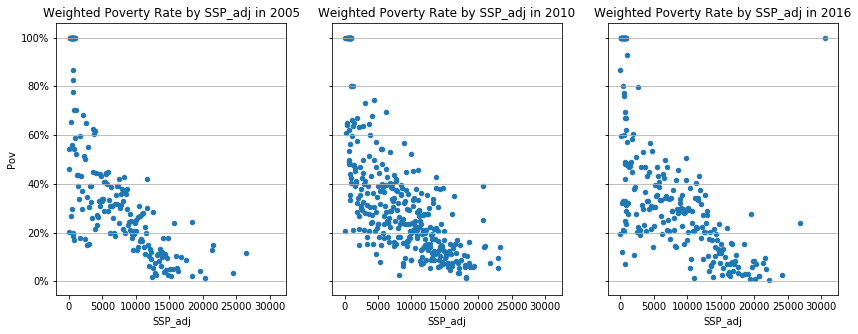

In [97]:
n = 9
scatter_sub(cats, acs_vars[n])

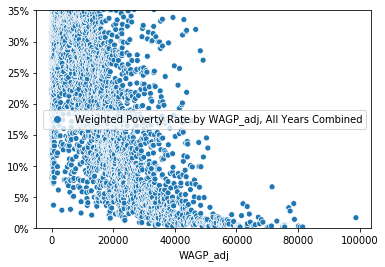

In [98]:
n = 10
scatter_combined(cats, acs_vars[n])

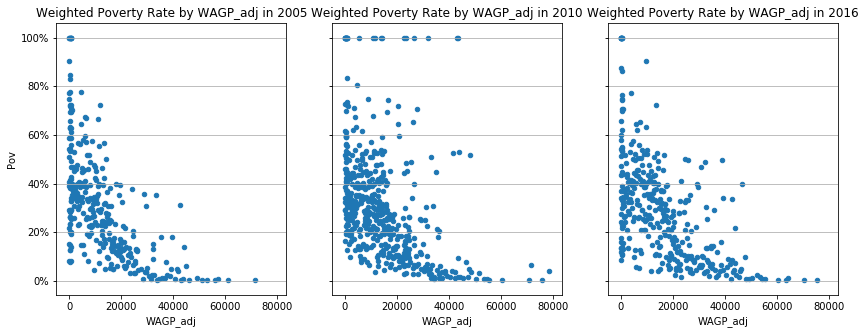

In [99]:
n = 10
scatter_sub(cats, acs_vars[n])

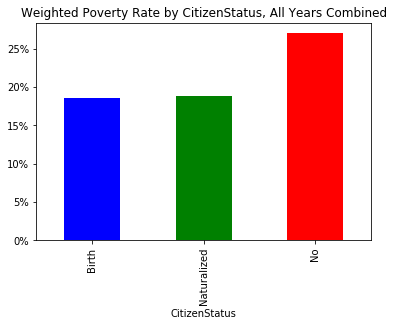

In [100]:
n = 0
bar_combined(cats, nyc_vars[n])

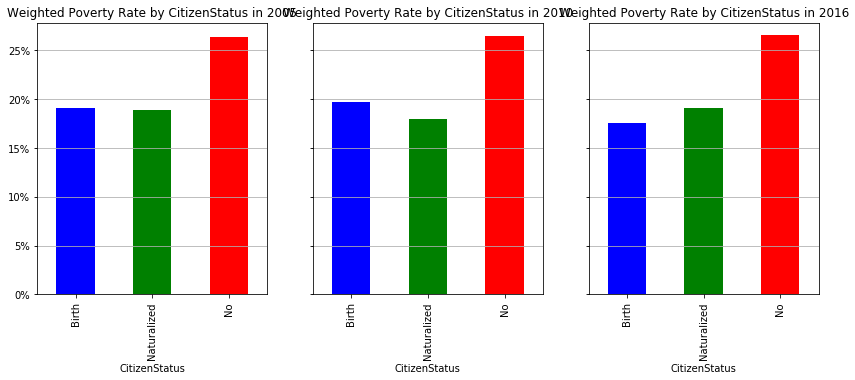

In [101]:
n = 0
bar_sub(cats, nyc_vars[n])

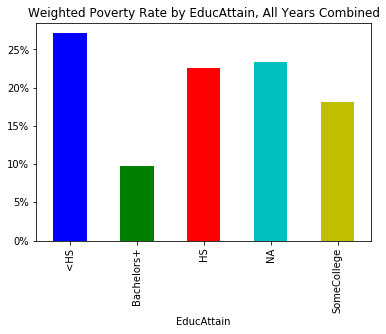

In [102]:
n = 1
bar_combined(cats, nyc_vars[n])

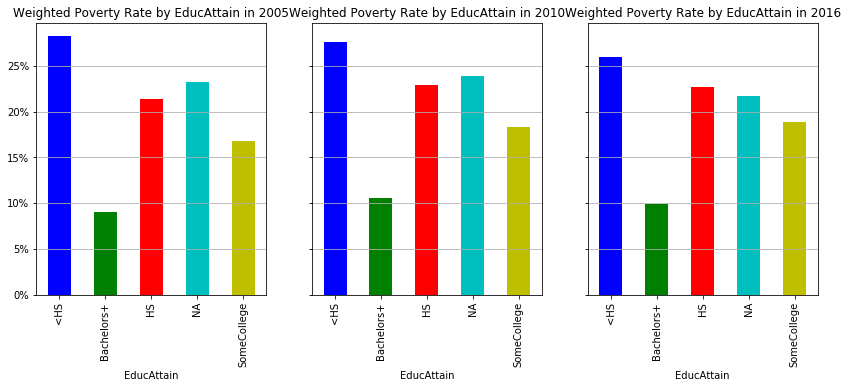

In [103]:
n = 1
bar_sub(cats, nyc_vars[n])

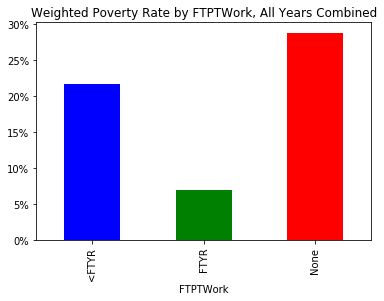

In [104]:
n = 2
bar_combined(cats, nyc_vars[n])

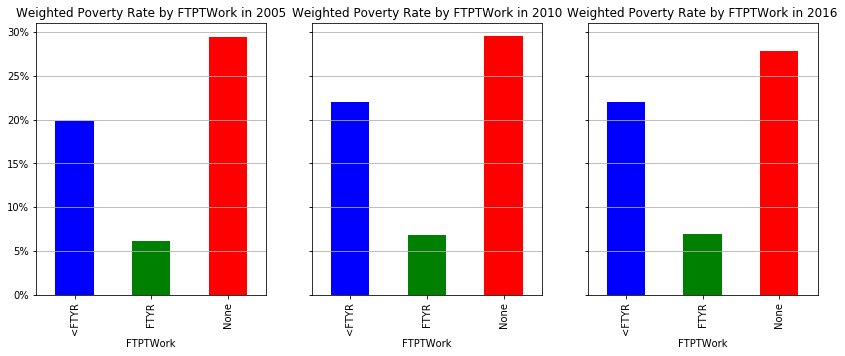

In [105]:
n = 2
bar_sub(cats, nyc_vars[n])

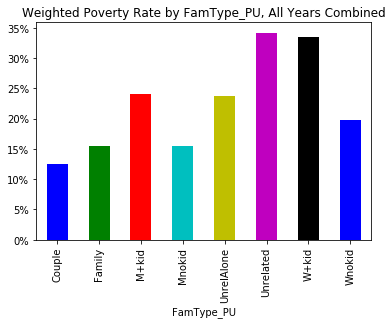

In [106]:
n = 3
bar_combined(cats, nyc_vars[n])

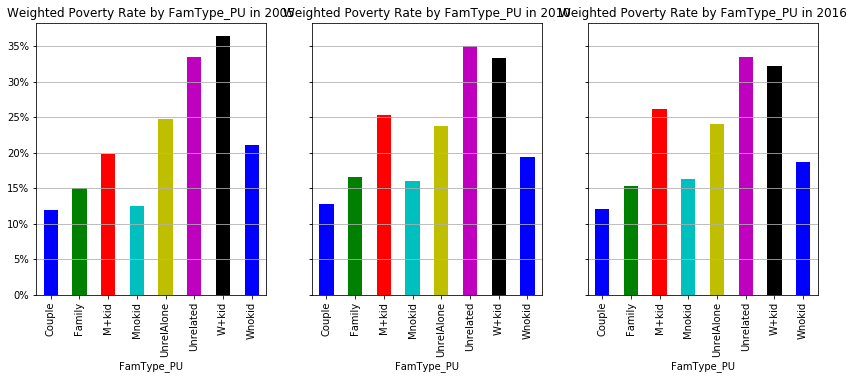

In [107]:
n = 3
bar_sub(cats, nyc_vars[n])

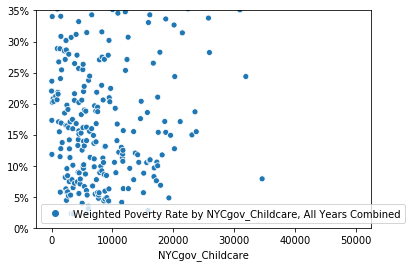

In [108]:
n = 4
scatter_combined(cats, nyc_vars[n])

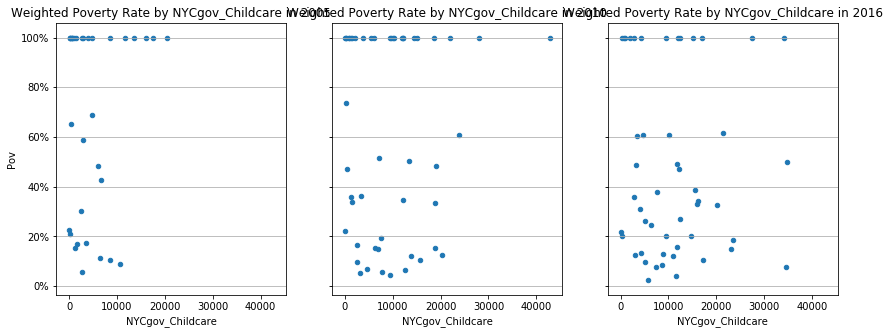

In [109]:
n = 4
scatter_sub(cats, nyc_vars[n])

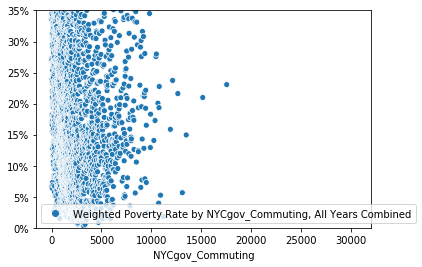

In [110]:
n = 5
scatter_combined(cats, nyc_vars[n])

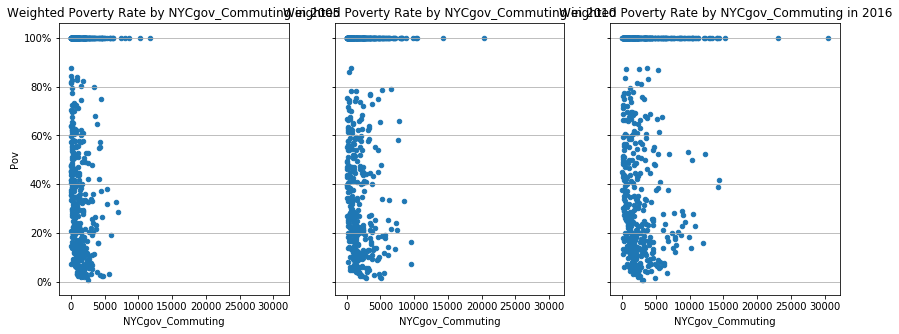

In [111]:
n = 5
scatter_sub(cats, nyc_vars[n])

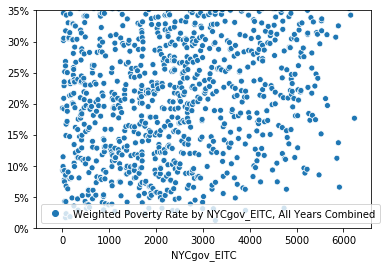

In [112]:
n = 6
scatter_combined(cats, nyc_vars[n])

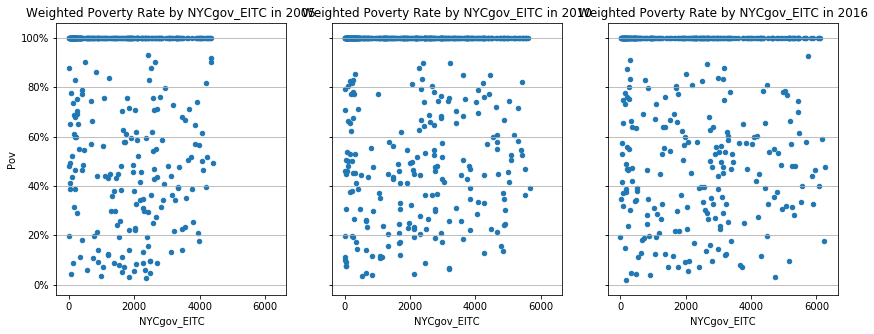

In [113]:
n = 6
scatter_sub(cats, nyc_vars[n])

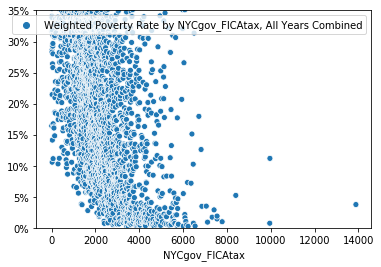

In [114]:
n = 7
scatter_combined(cats, nyc_vars[n])

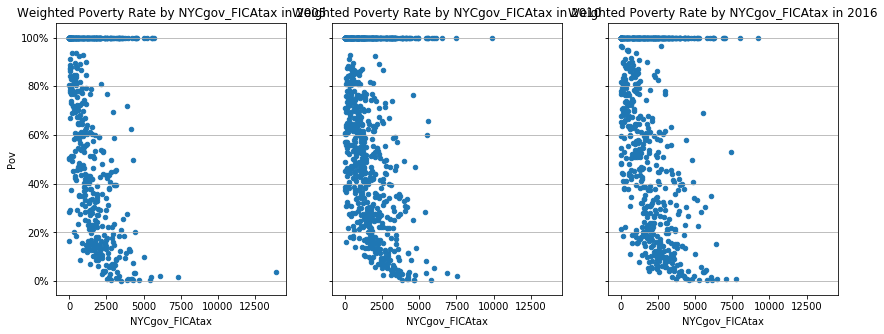

In [115]:
n = 7
scatter_sub(cats, nyc_vars[n])

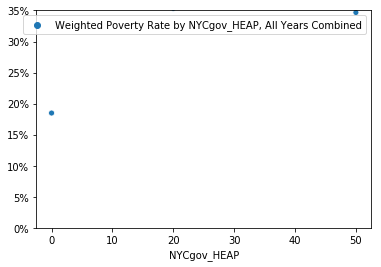

In [116]:
n = 8
scatter_combined(cats, nyc_vars[n])

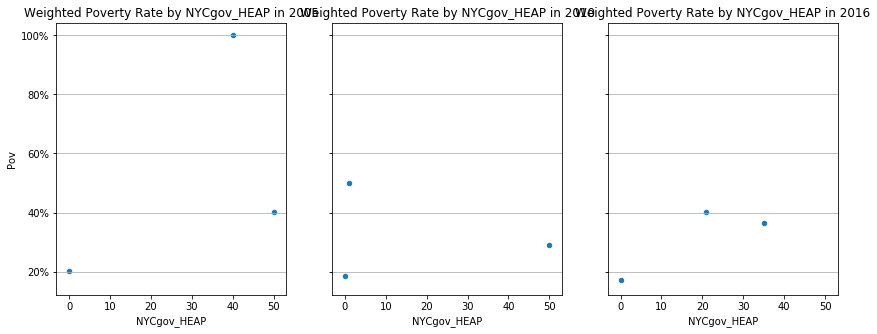

In [117]:
n = 8
scatter_sub(cats, nyc_vars[n])

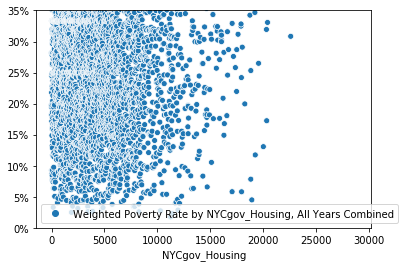

In [118]:
n = 9
scatter_combined(cats, nyc_vars[n])

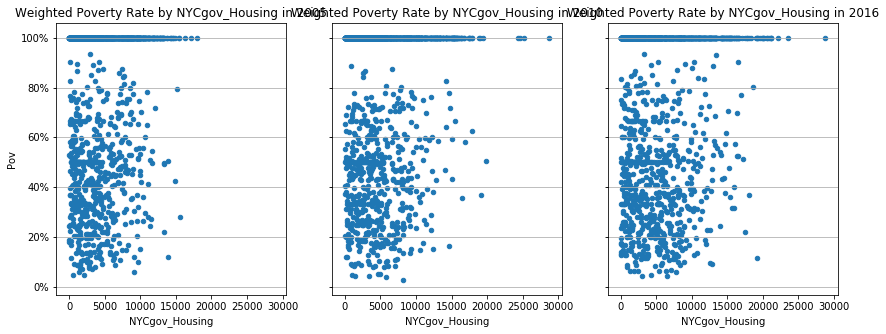

In [119]:
n = 9
scatter_sub(cats, nyc_vars[n])

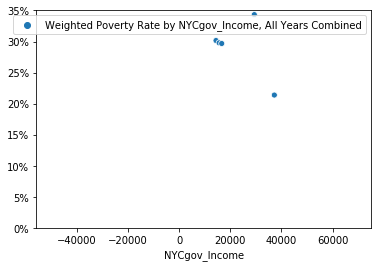

In [120]:
n = 10
scatter_combined(cats, nyc_vars[n])

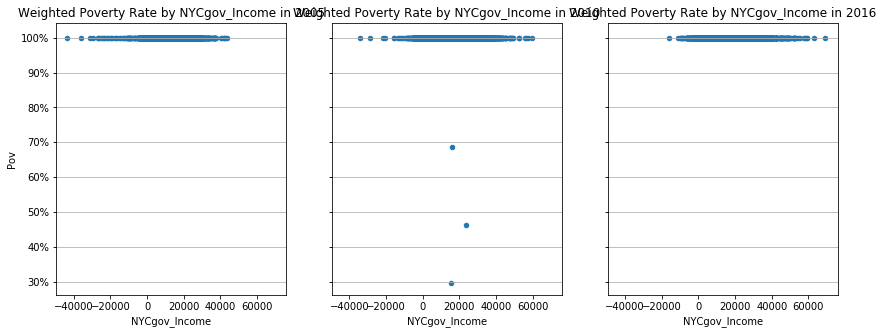

In [121]:
n = 10
scatter_sub(cats, nyc_vars[n])

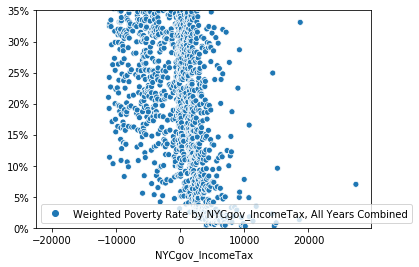

In [122]:
n = 11
scatter_combined(cats, nyc_vars[n])

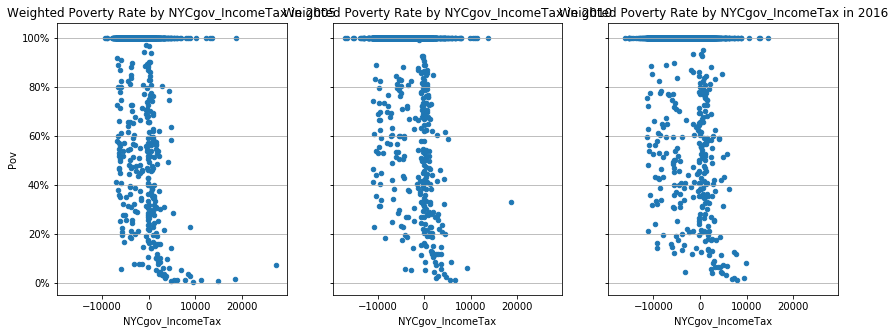

In [123]:
n = 11
scatter_sub(cats, nyc_vars[n])

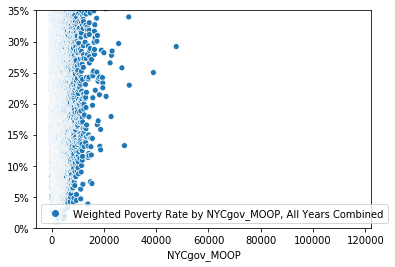

In [124]:
n = 12
scatter_combined(cats, nyc_vars[n])

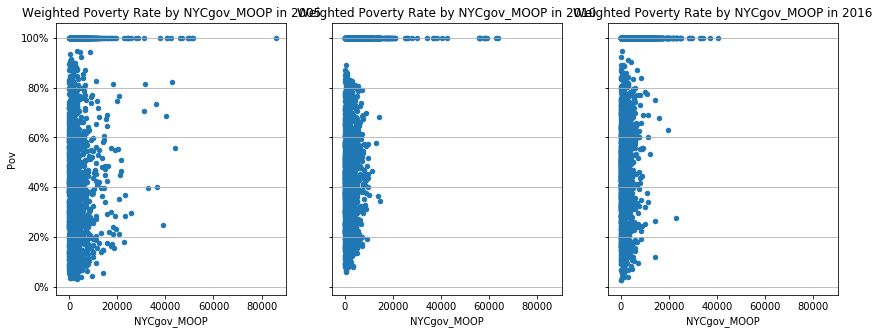

In [125]:
n = 12
scatter_sub(cats, nyc_vars[n])

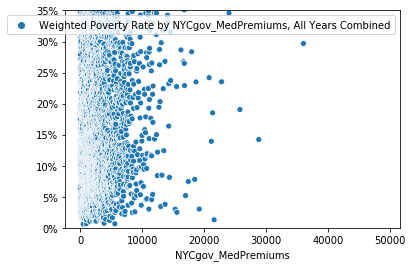

In [126]:
n = 13
scatter_combined(cats, nyc_vars[n])

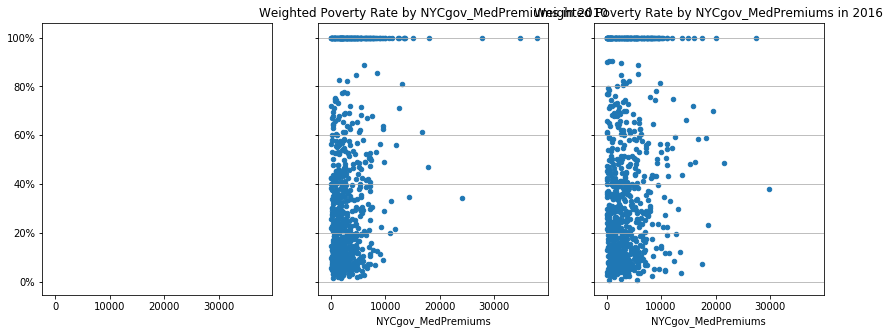

In [127]:
n = 13
scatter_sub(cats, nyc_vars[n])

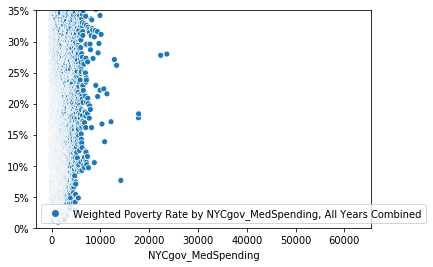

In [128]:
n = 14
scatter_combined(cats, nyc_vars[n])

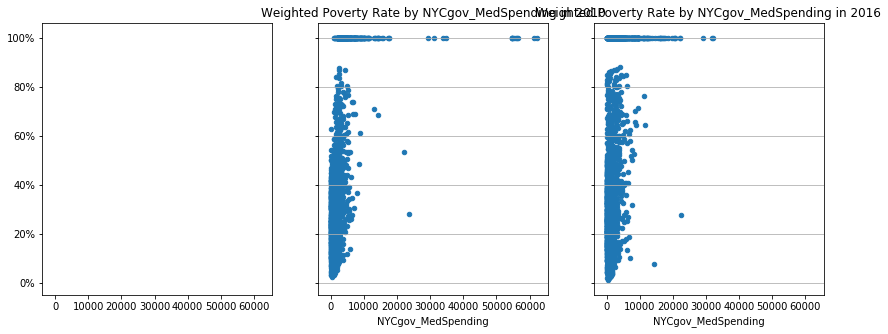

In [129]:
n = 14
scatter_sub(cats, nyc_vars[n])

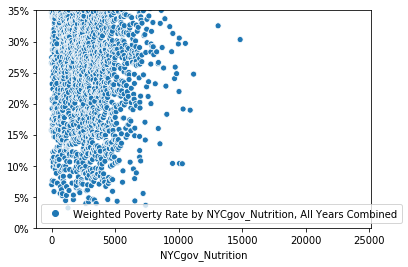

In [130]:
n = 15
scatter_combined(cats, nyc_vars[n])

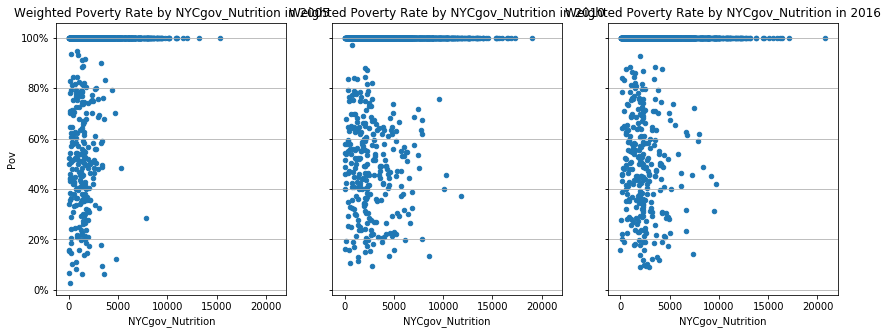

In [131]:
n = 15
scatter_sub(cats, nyc_vars[n])

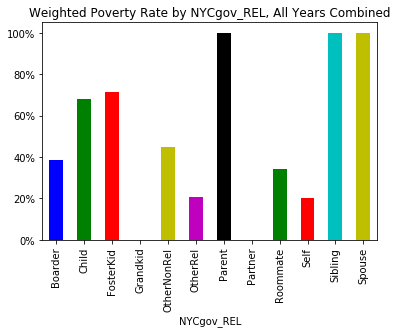

In [132]:
n = 16
bar_combined(cats, nyc_vars[n])

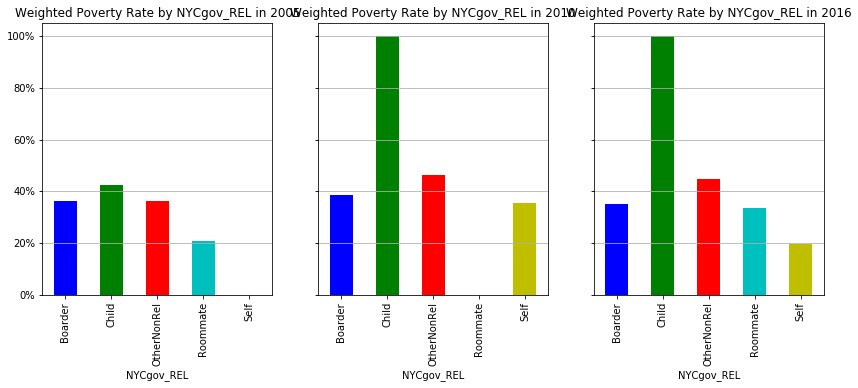

In [133]:
n = 16
bar_sub(cats, nyc_vars[n])

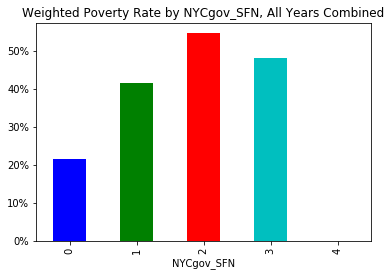

In [134]:
n = 17
bar_combined(cats, nyc_vars[n])

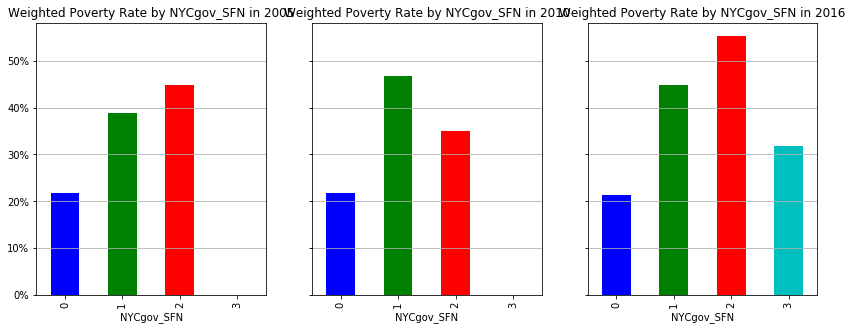

In [135]:
n = 17
bar_sub(cats, nyc_vars[n])

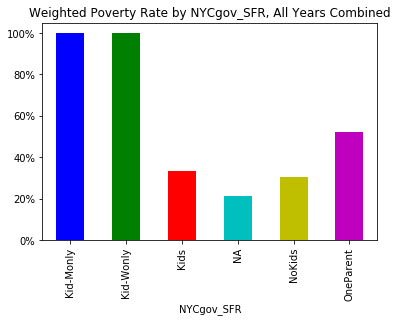

In [136]:
n = 18
bar_combined(cats, nyc_vars[n])

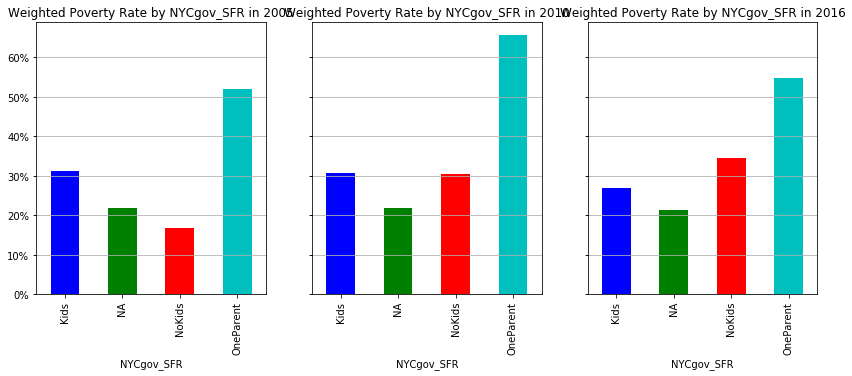

In [137]:
n = 18
bar_sub(cats, nyc_vars[n])

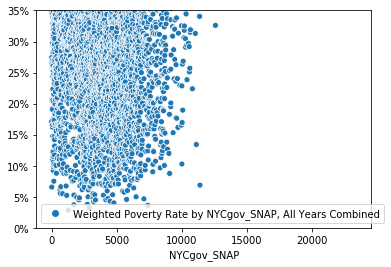

In [138]:
n = 19
scatter_combined(cats, nyc_vars[n])

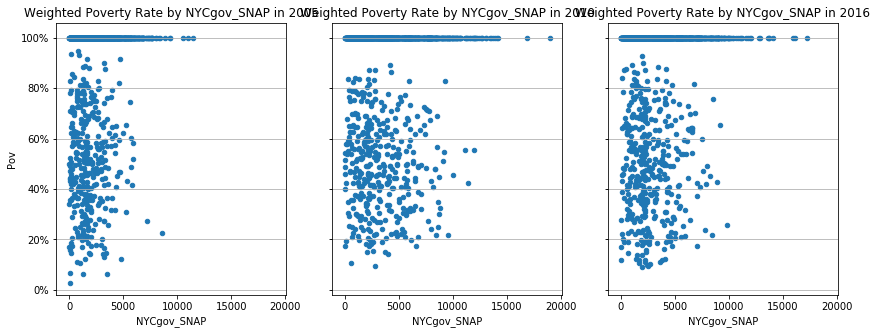

In [139]:
n = 19
scatter_sub(cats, nyc_vars[n])

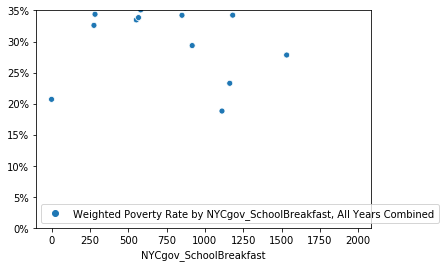

In [140]:
n = 20
scatter_combined(cats, nyc_vars[n])

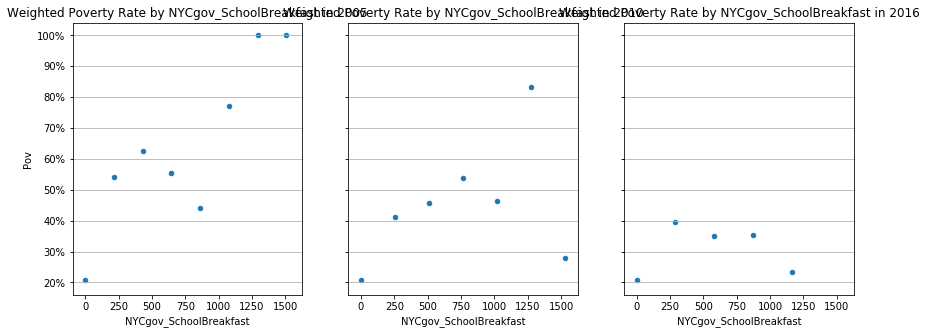

In [141]:
n = 20
scatter_sub(cats, nyc_vars[n])

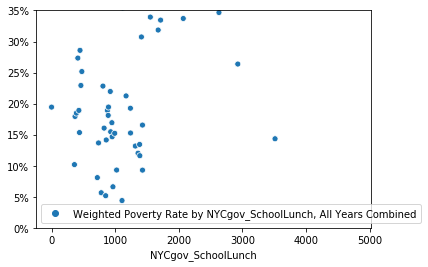

In [142]:
n = 21
scatter_combined(cats, nyc_vars[n])

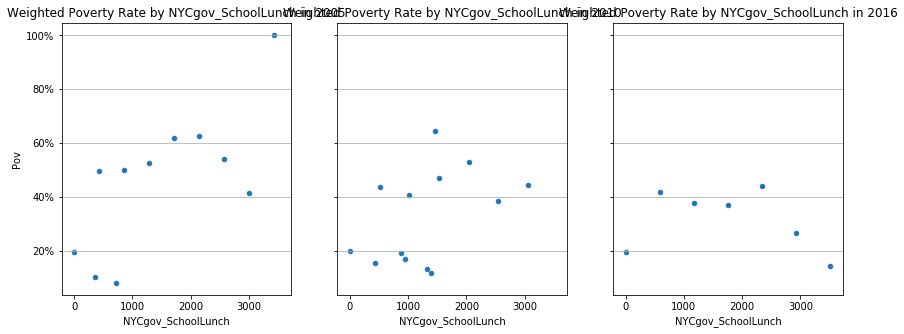

In [143]:
n = 21
scatter_sub(cats, nyc_vars[n])

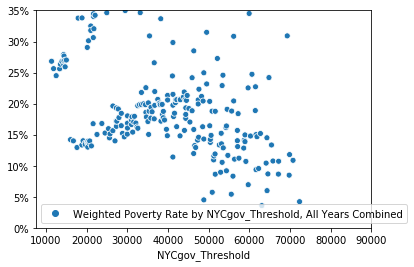

In [144]:
n = 22
scatter_combined(cats, nyc_vars[n])

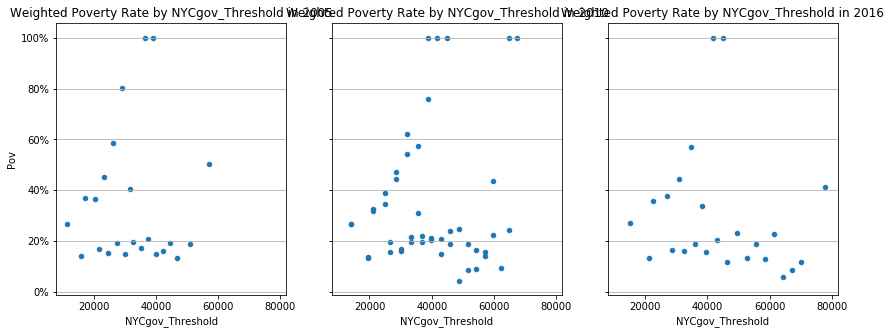

In [145]:
n = 22
scatter_sub(cats, nyc_vars[n])

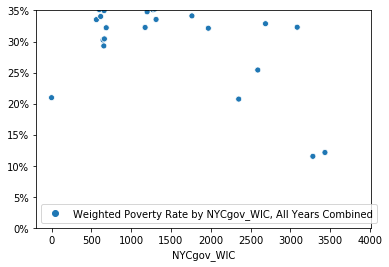

In [146]:
n = 23
scatter_combined(cats, nyc_vars[n])

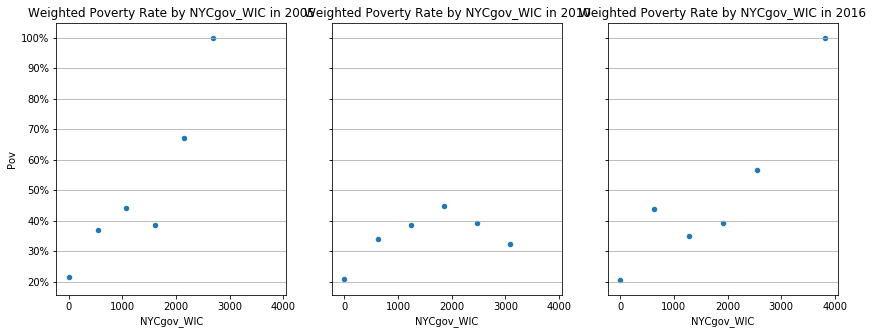

In [147]:
n = 23
scatter_sub(cats, nyc_vars[n])

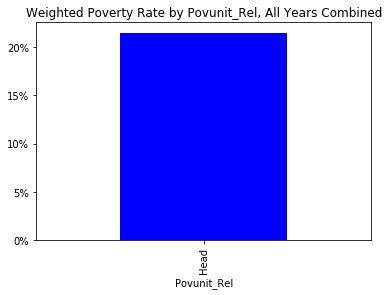

In [148]:
n = 24
bar_combined(cats, nyc_vars[n])

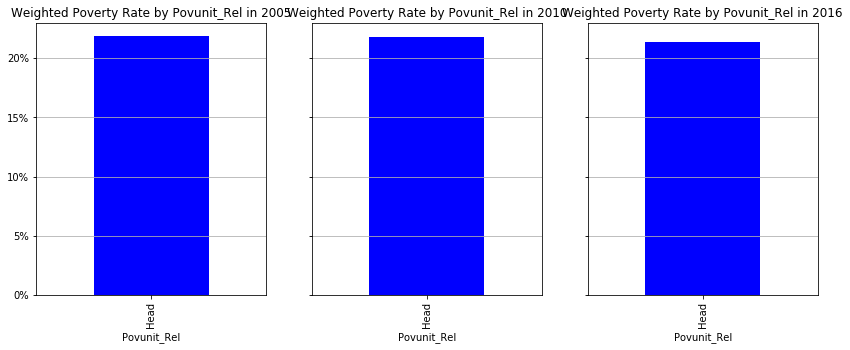

In [149]:
n = 24
bar_sub(cats, nyc_vars[n])

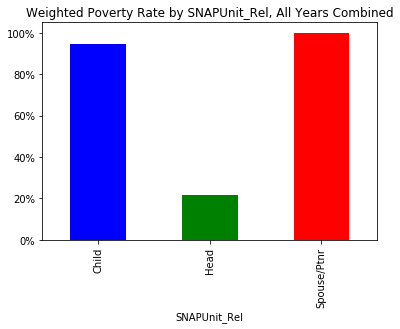

In [150]:
n = 25
bar_combined(cats, nyc_vars[n])

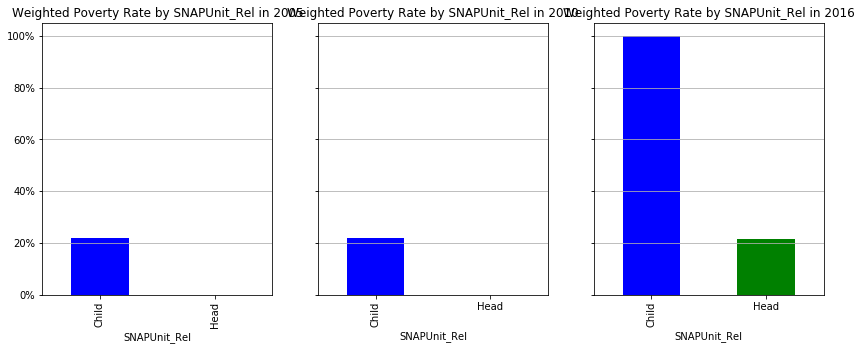

In [151]:
n = 25
bar_sub(cats, nyc_vars[n])

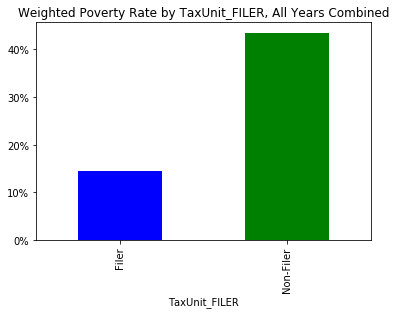

In [152]:
n = 26
bar_combined(cats, nyc_vars[n])

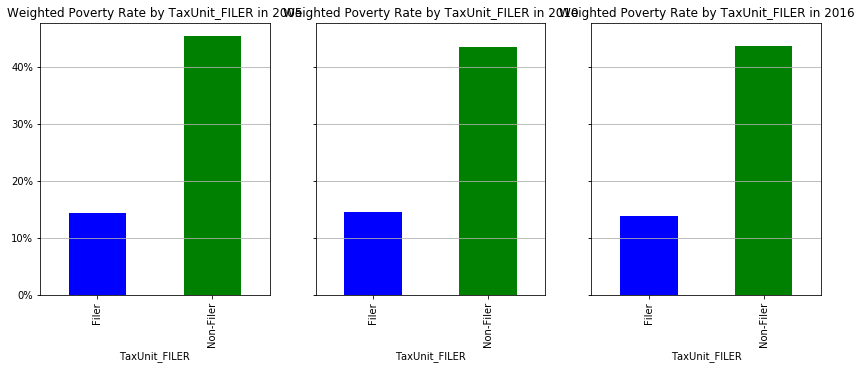

In [153]:
n = 26
bar_sub(cats, nyc_vars[n])

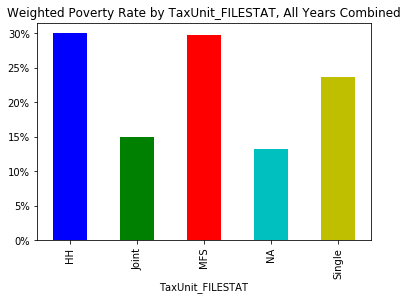

In [154]:
n = 27
bar_combined(cats, nyc_vars[n])

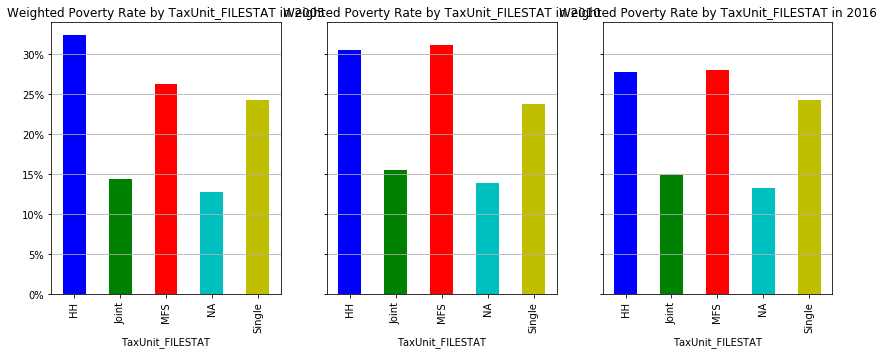

In [155]:
n = 27
bar_sub(cats, nyc_vars[n])

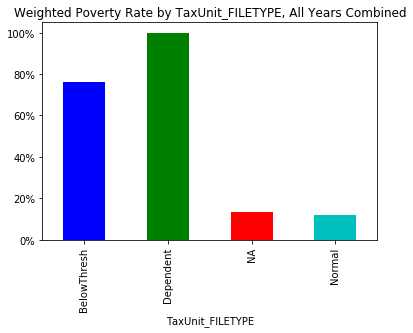

In [156]:
n = 28
bar_combined(cats, nyc_vars[n])

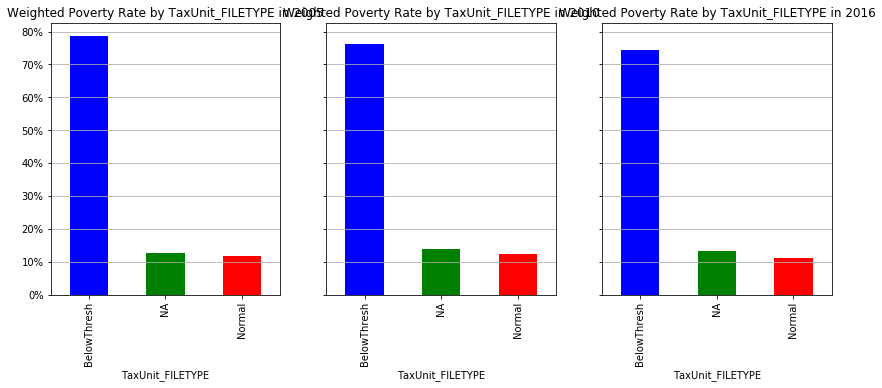

In [157]:
n = 28
bar_sub(cats, nyc_vars[n])

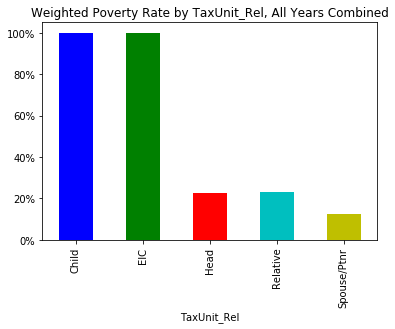

In [158]:
n = 29
bar_combined(cats, nyc_vars[n])

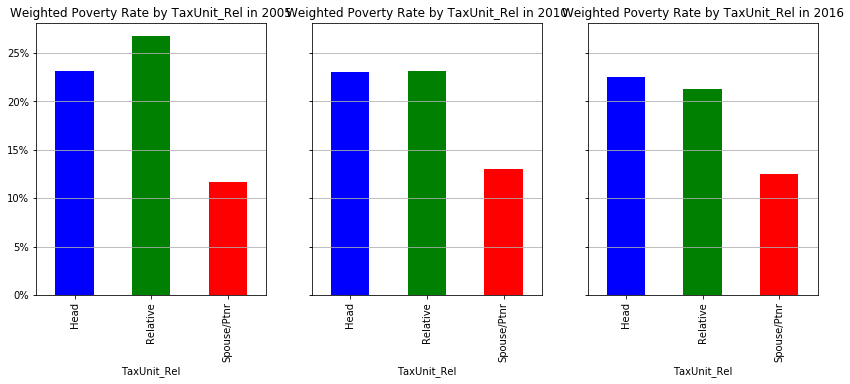

In [159]:
n = 29
bar_sub(cats, nyc_vars[n])

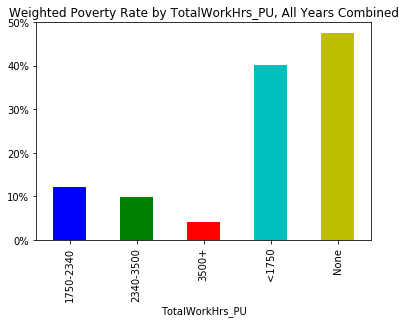

In [160]:
n = 30
bar_combined(cats, nyc_vars[n])

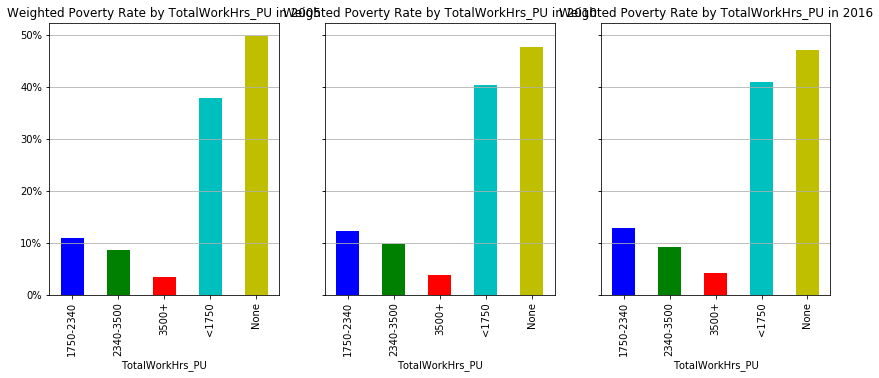

In [161]:
n = 30
bar_sub(cats, nyc_vars[n])

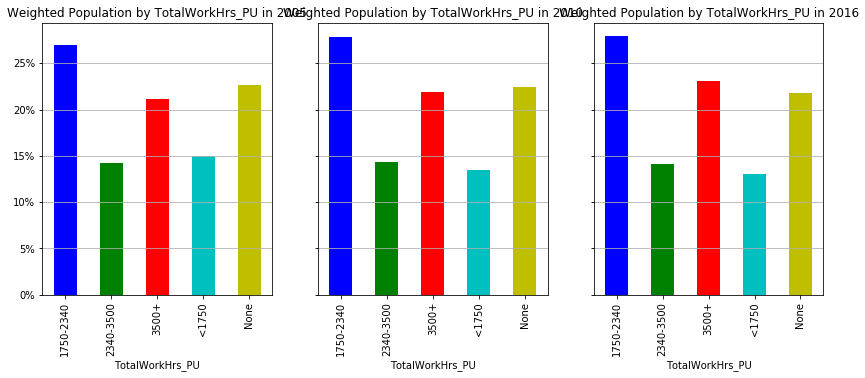

In [162]:
n = 30
bar_sub_stat(cats, nyc_vars[n])